# Imports

In [1]:
import os
os.getcwd()
import anndata
import pandas as pd
import omicverse as ov
ov.ov_plot_set()
import omicverse as ov
import scanpy as sc
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd
from anndata import AnnData


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.5, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


In [2]:
import matplotlib.pyplot as plt

# Set global rcParams for consistent formatting
plt.rcParams['figure.facecolor'] = 'white'  # White background for the figure
plt.rcParams['axes.facecolor'] = 'white'  # White background for the axes
plt.rcParams['savefig.facecolor'] = 'white'  # White background for saved figures
plt.rcParams['legend.frameon'] = True  # Show legend frame
plt.rcParams['legend.edgecolor'] = 'black'  # Black legend border
plt.rcParams['legend.labelcolor'] = 'black'  # Black legend text
plt.rcParams['legend.fontsize'] = 12  # Legend font size
plt.rcParams['axes.labelcolor'] = 'black'  # Axis labels color
plt.rcParams['xtick.color'] = 'black'  # X-axis ticks color
plt.rcParams['ytick.color'] = 'black'  # Y-axis ticks color
plt.rcParams['text.color'] = 'black'  # Default text color

# Read data 

In [3]:
sample_metadata = pd.read_table(r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/GCF-2024-926_samplesheet.tsv")
sample_metadata.set_index("Sample_ID",inplace=True)
# Standardize naming convention from Sample_Biosource
mapp_dict = {
	"Lung": ["Lung","Bronchus","bronkus","Bronchus/lung","Bronchial mucosa"],
	"Lymph Node" : ["Lymph node","EBUS lymfe 4R","Lymph node 11R","Lymph node 4R","Lymph node stasjon 7"]
}
n_mapp_dict = {v:k for k, l in mapp_dict.items() for v in l}
sample_metadata.replace({"Sample_Biosource":n_mapp_dict}, inplace=True)


In [4]:
gene_info = pd.read_table(r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/QC_GCF-2024-926/bfq/exprs/gene_info.tsv")
gene_info.drop(columns=["Unnamed: 0"], inplace=True)
gene_info.set_index("gene_id",inplace=True)

In [5]:
transcript_counts = pd.read_table(r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/QC_GCF-2024-926/bfq/exprs/transcript_counts.tsv")

In [6]:
gene_counts = pd.read_table(r"/mnt/archive/THORA/mRNA_tissue_GCF-2024-926/QC_GCF-2024-926/bfq/exprs/gene_counts.tsv")
gene_counts.set_index(["Unnamed: 0"], inplace=True)
gene_counts.index.rename("ENSG", inplace=True)
gene_counts = gene_counts.round(0).astype(int)
# Count all the zeros
df_zeros = (gene_counts == 0).all(axis=1)
# Subset the gene_counts to remove all of the rows that only have zeros in them
gene_counts = gene_counts[~df_zeros]
#Confirm that the subset was done correctly
gene_counts.shape[0] - df_zeros.sum() == gene_counts.shape[0]
gene_counts

R1_28  R1_79  R2_07  R2_22  R2_30  R1_74  R1_19  R2_29  \
ENSG                                                                      
ENSG00000000003    105    171    288     48    151    226     36     57   
ENSG00000000419    423    476    753    271    313    226    179    247   
ENSG00000000457     55    198    549    113     80     88     66     30   
ENSG00000000460     99    393    956    222    365    121    311    138   
ENSG00000000938      4     27     13     14     16      8    435     18   
...                ...    ...    ...    ...    ...    ...    ...    ...   
ENSG00000291313      8      0     18     41      0      0      0      4   
ENSG00000291314      0      0      0      0      0      0      0      0   
ENSG00000291315      0      5      6      0      0      0      0      0   
ENSG00000291316      0      0      0     11      1      0      0      5   
ENSG00000291317      5     28     37     30      0     25    165     36   

                 R2_60  R1_81  ...  R1_26  R2_06  R2_02  R2_08  R2_56  R2_12  \
ENSG                           ...                                             
ENSG00000000003     95    117  ...    212    137     21     44    143     66   
ENSG00000000419    211    201  ...    481    765    210    165    331    134   
ENSG00000000457     85     98  ...    150    213    180     46    127    140   
ENSG00000000460     72    108  ...    160    110     53     33     78    129   
ENSG00000000938     17      6  ...      6   1494     36      2     52     48   
...                ...    ...  ...    ...    ...    ...    ...    ...    ...   
ENSG00000291313      0      0  ...      1    157     54      0      0      0   
ENSG00000291314      0      0  ...      0      0      0      0      0      0   
ENSG00000291315      0      0  ...      0      0      0      0      2      0   
ENSG00000291316      0      0  ...      0      0     27      0     16      0   
ENSG00000291317      0     23  ...     32     50     55     18     35     15   

                 R2_33  R2_36  R2_68  R1_62  
ENSG                                         
ENSG00000000003    206    177    249    105  
ENSG00000000419    328    250    529    286  
ENSG00000000457    162    131    249     53  
ENSG00000000460    315    300    504     37  
ENSG00000000938     12     23     15    188  
...                ...    ...    ...    ...  
ENSG00000291313     17     51     11      0  
ENSG00000291314      0      0      0      0  
ENSG00000291315      1      0      0      0  
ENSG00000291316      0      0      0      0  
ENSG00000291317     25     17     67     22  

[51620 rows x 95 columns]

In [7]:
adata = anndata.AnnData(X=gene_counts.T)
adata.var = gene_info.loc[adata.var_names]
adata.obs = sample_metadata.loc[adata.obs_names]
adata.obs["batch"] = "mRNA"
adata.var.reset_index(inplace=True)
adata.var.set_index(keys="gene_name",inplace=True)


In [8]:
for i, (g_name, ensg) in enumerate(zip(adata.var.index, adata.var["ENSG"])):
	if pd.isna(g_name):
		adata.var.index.values[i] = ensg
	else:
		continue

In [9]:
raw_data=adata.to_df().T
raw_data.head()


R1_28  R1_79  R2_07  R2_22  R2_30  R1_74  R1_19  R2_29  R2_60  \
gene_name                                                                  
TSPAN6       105    171    288     48    151    226     36     57     95   
DPM1         423    476    753    271    313    226    179    247    211   
SCYL3         55    198    549    113     80     88     66     30     85   
C1orf112      99    393    956    222    365    121    311    138     72   
FGR            4     27     13     14     16      8    435     18     17   

           R1_81  ...  R1_26  R2_06  R2_02  R2_08  R2_56  R2_12  R2_33  R2_36  \
gene_name         ...                                                           
TSPAN6       117  ...    212    137     21     44    143     66    206    177   
DPM1         201  ...    481    765    210    165    331    134    328    250   
SCYL3         98  ...    150    213    180     46    127    140    162    131   
C1orf112     108  ...    160    110     53     33     78    129    315    300   
FGR            6  ...      6   1494     36      2     52     48     12     23   

           R2_68  R1_62  
gene_name                
TSPAN6       249    105  
DPM1         529    286  
SCYL3        249     53  
C1orf112     504     37  
FGR           15    188  

[5 rows x 95 columns]

In [10]:
wanted_samples =adata.obs[adata.obs["Sample_Biosource"].isin(["Lung","Lymph Node"])].index
adata = adata[wanted_samples,:]
adata.var_names_make_unique()

# QC

In [10]:
dc.plot_filter_by_expr(adata, group='Sample_Biosource', min_count=10, min_total_count=15, large_n=2, min_prop=1)

ValueError: cannot convert float NaN to integer

In [11]:
genes = dc.filter_by_expr(adata, group='Sample_Biosource', min_count=10, min_total_count=15, large_n=1, min_prop=1)

In [12]:
adata = adata[:, genes].copy()


# Count matrix

In [13]:
count_matrix = pd.DataFrame(adata.X, adata.obs.index, adata.var_names).T
count_matrix.index.name = None

In [14]:
count_matrix_unt = pd.DataFrame(adata.X, adata.obs.index, adata.var_names)


# Differential Expression Analysis

## Establish groups/conditions

In [15]:
lung_samples=adata.obs[adata.obs["Sample_Biosource"].isin(["Lung"])].index


In [16]:
node_samples=adata.obs[adata.obs["Sample_Biosource"].isin(["Lymph Node"])].index


## Omicverse (wrapper of pydeseq2)

In [96]:

dds=ov.bulk.pyDEG(count_matrix)
dds.drop_duplicates_index()
dds.normalize()
result=dds.deg_analysis(lung_samples,node_samples,method='ttest')

In [97]:
result.head()


pvalue    qvalue  FoldChange    MaxBaseMean      BaseMean  \
MALAT1  0.324761  0.660642    1.097315  102060.759529  97534.934780   
RN7SK   0.000043  0.008720    0.580522   58506.520005  46234.480349   
RN7SL2  0.051146  0.304666    0.658493   53030.184234  43974.332343   
NEAT1   0.822770  0.937432    1.051977   32404.694869  31604.049759   
RN7SL1  0.229117  0.573943    0.762345   34486.155769  30387.727444   

        log2(BaseMean)    log2FC  abs(log2FC)      size  -log(pvalue)  \
MALAT1       16.573631  0.133978     0.133978  0.109732      0.488436   
RN7SK        15.496682 -0.784578     0.784578  0.058052      4.368412   
RN7SL2       15.424374 -0.602760     0.602760  0.065849      1.291186   
NEAT1        14.947822  0.073103     0.073103  0.105198      0.084721   
RN7SL1       14.891201 -0.391483     0.391483  0.076235      0.639942   

        -log(qvalue)     sig  
MALAT1      0.180034  normal  
RN7SK       2.059474     sig  
RN7SL2      0.516176  normal  
NEAT1       0.028060  normal  
RN7SL1      0.241132  normal

In [98]:
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=6)

... Fold change threshold: 0.5230459636622138


<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

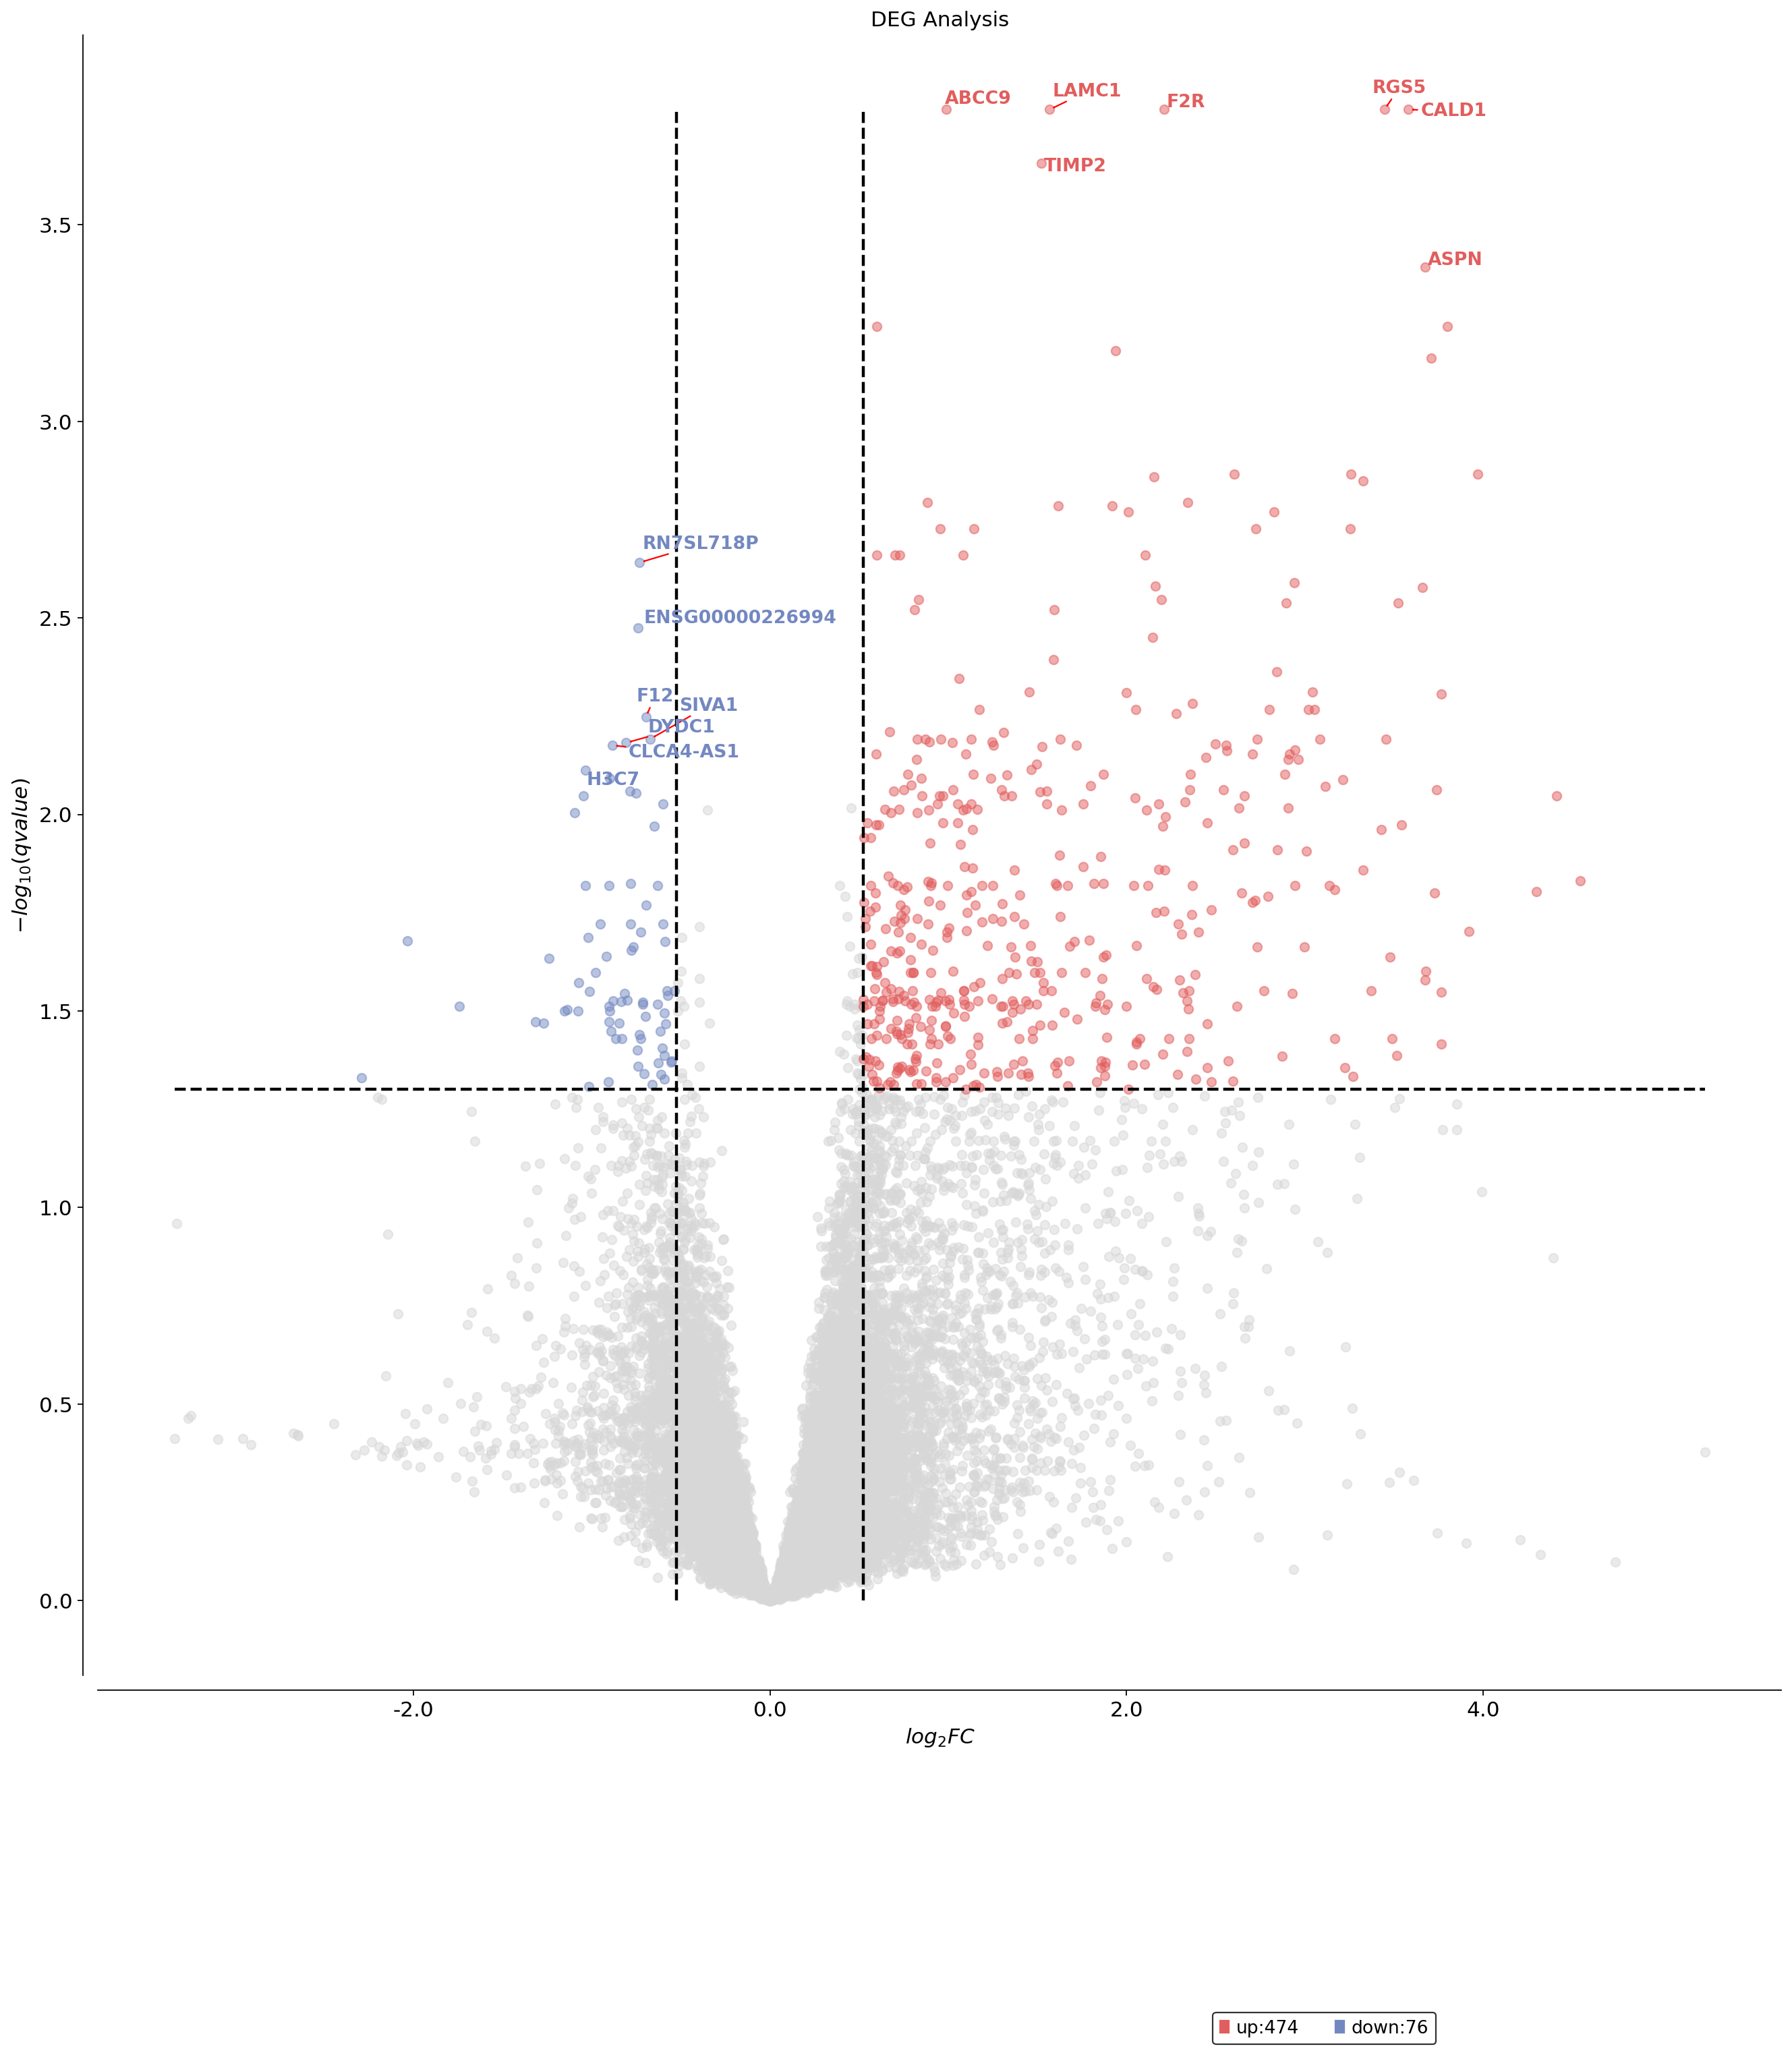

In [102]:
dds.plot_volcano(title='DEG Analysis',figsize=(20,20),
                 plot_genes_num=15,plot_genes_fontsize=12,)

(<Figure size 960x960 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

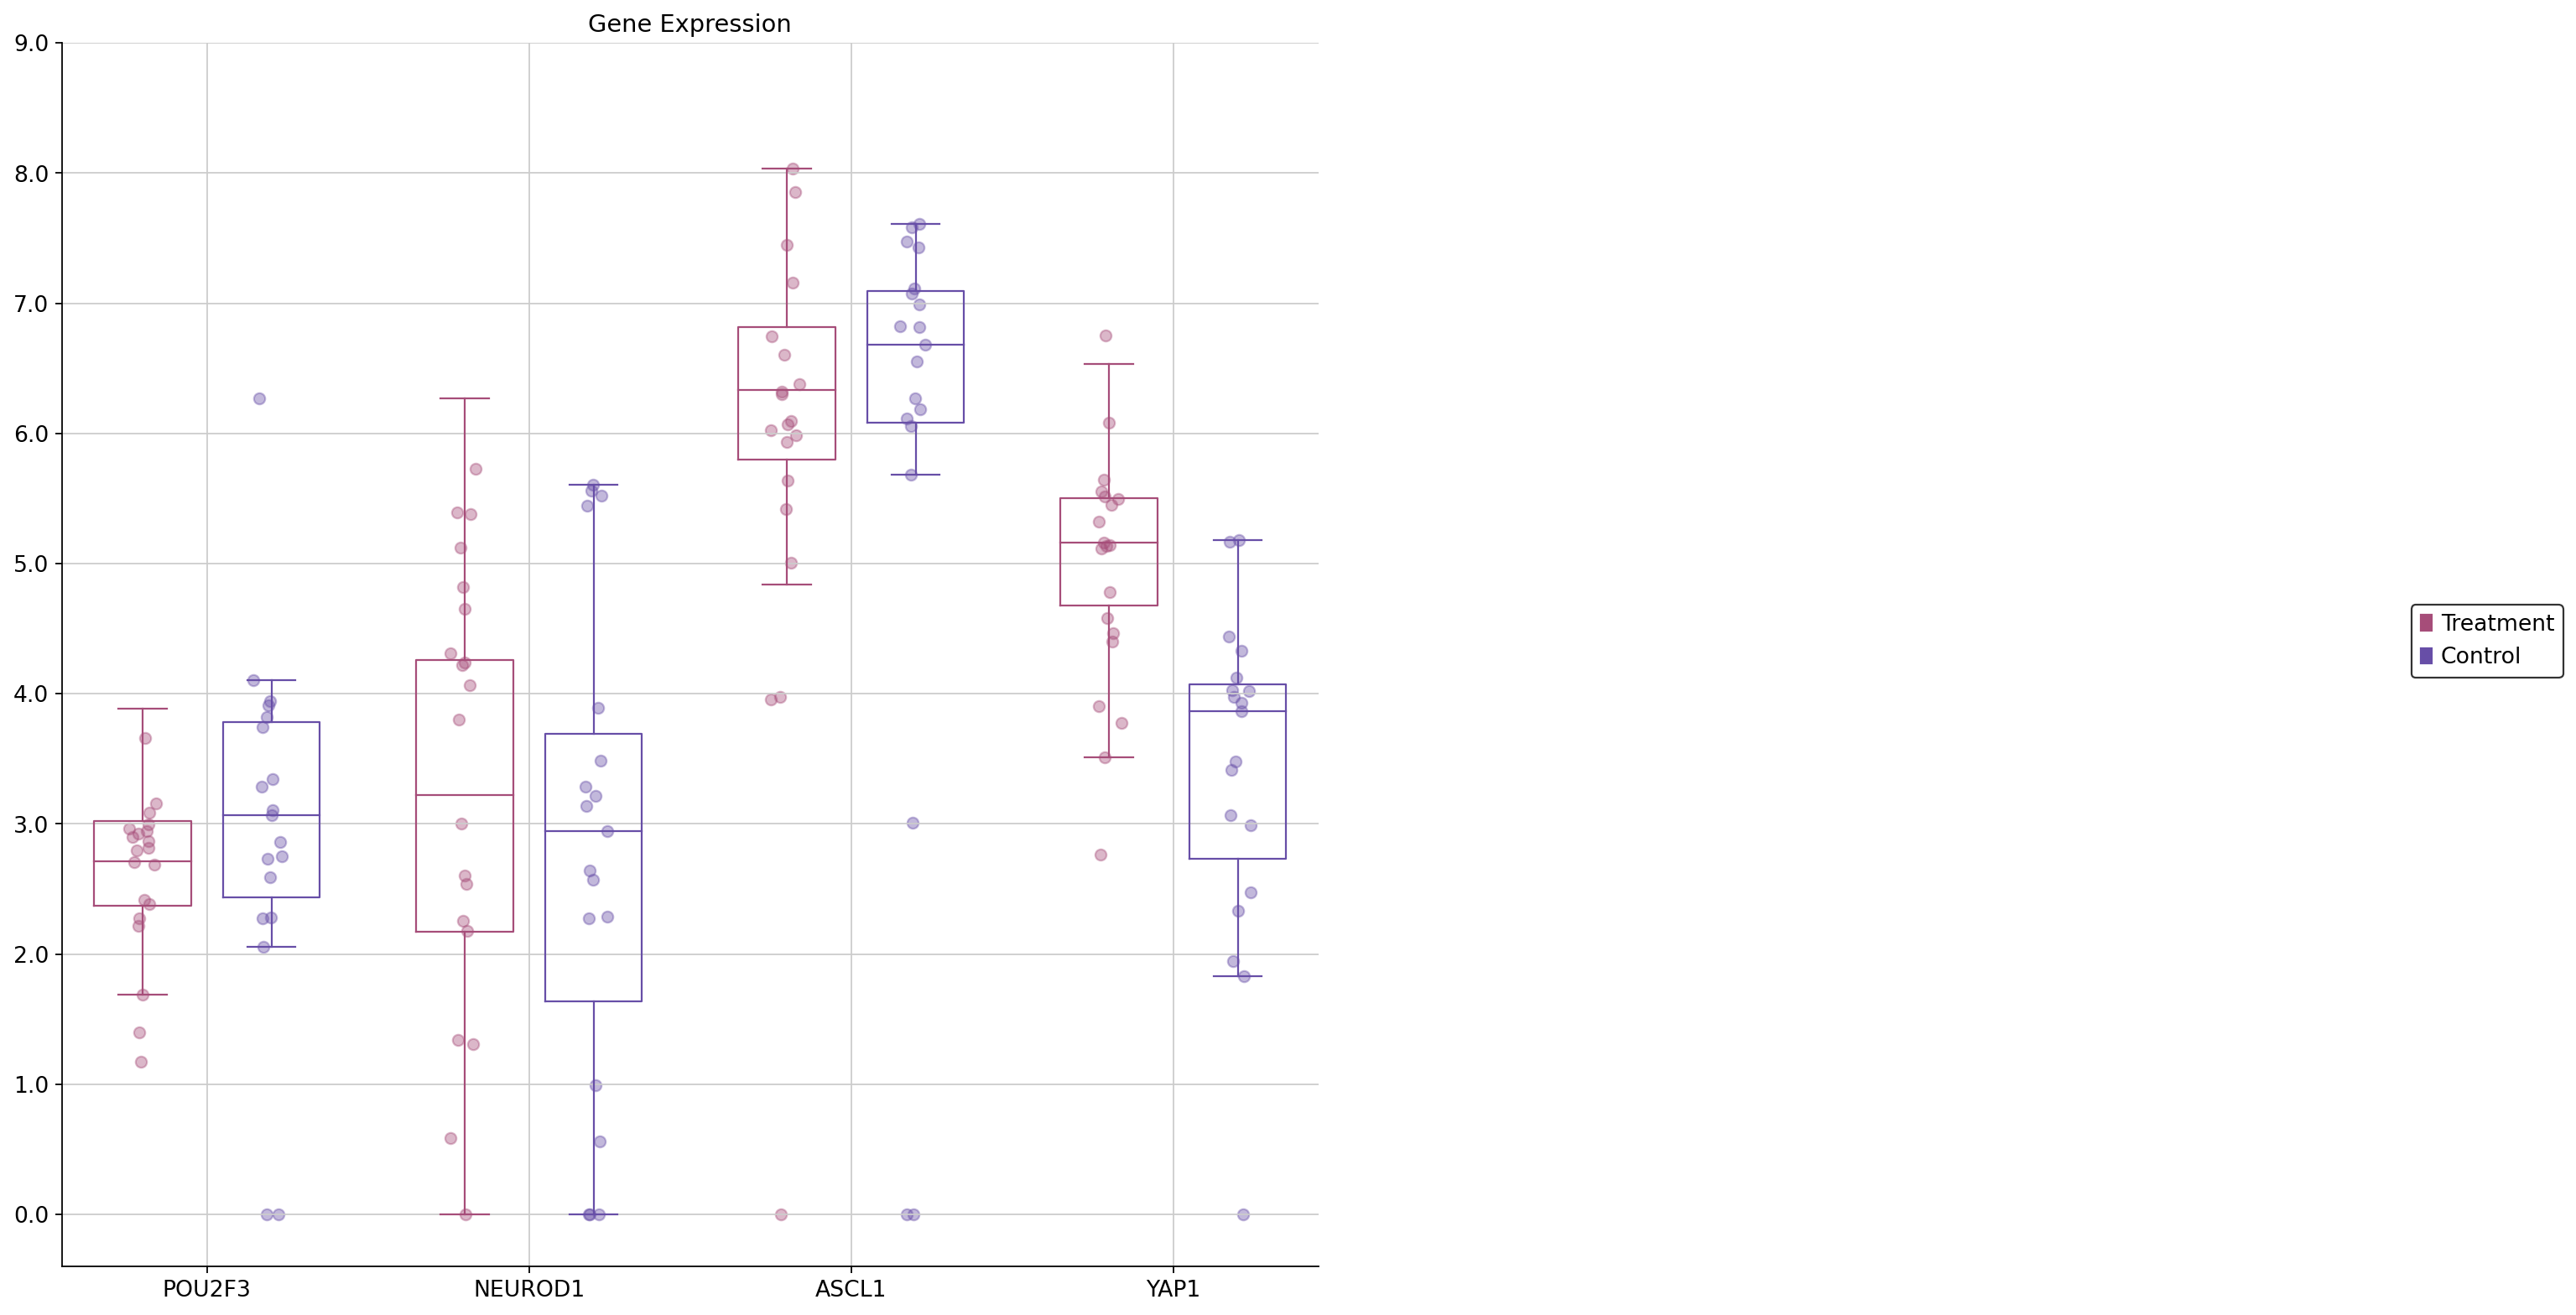

In [104]:
dds.plot_boxplot(genes=['NEUROD1','POU2F3',"ASCL1","YAP1"],treatment_groups=lung_samples,
    control_groups=node_samples,fontsize=12,figsize=(12,12),
        legend_bbox=(2,0.55))  

## pyDESeq2

In [17]:
dds = DeseqDataSet(
    adata=adata,
    design_factors='Sample_Biosource',
    refit_cooks=True,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between Lung and Lymph node
stat_res = DeseqStats(
    dds,
    contrast=["Sample-Biosource","Lung","Lymph Node"],
)

# Compute the wald test
stat_res.summary()

results_df = stat_res.results_df



Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 2.17 seconds.

Fitting dispersion trend curve...
... done in 8.65 seconds.

Fitting MAP dispersions...
... done in 2.22 seconds.

Fitting LFCs...
... done in 2.91 seconds.

Refitting 846 outliers.

Fitting dispersions...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 0.39 seconds.

Fitting LFCs...
... done in 0.86 seconds.

Running Wald tests...
... done in 2.09 seconds.



Log2 fold change & Wald test p-value: Sample-Biosource Lung vs Lymph Node


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
TSPAN6           146.674774        0.114409  0.224153  0.510409  0.609765   
DPM1             346.873559       -0.389263  0.116197 -3.350035  0.000808   
SCYL3            147.033076       -0.126942  0.175449 -0.723524  0.469358   
C1orf112         192.452222        0.249136  0.246210  1.011882  0.311595   
FGR               37.267476        1.210276  0.518415  2.334571  0.019566   
...                     ...             ...       ...       ...       ...   
ENSG00000291288   11.240830       -1.023261  0.429015 -2.385142  0.017073   
ENSG00000291290   18.969014       -0.979190  0.466265 -2.100072  0.035723   
ENSG00000291299  186.061476        0.004276  0.158382  0.026996  0.978463   
ENSG00000291313   10.088910       -0.838987  1.117065 -0.751064  0.452614   
TMEM276           33.197971        0.098720  0.357273  0.276315  0.782306   

                     padj  
TSPAN6           0.856587  
DPM1             0.016314  
SCYL3            0.771370  
C1orf112         0.652558  
FGR              0.153292  
...                   ...  
ENSG00000291288  0.140770  
ENSG00000291290  0.220646  
ENSG00000291299  0.995528  
ENSG00000291313  0.761548  
TMEM276          0.929361  

[23219 rows x 6 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


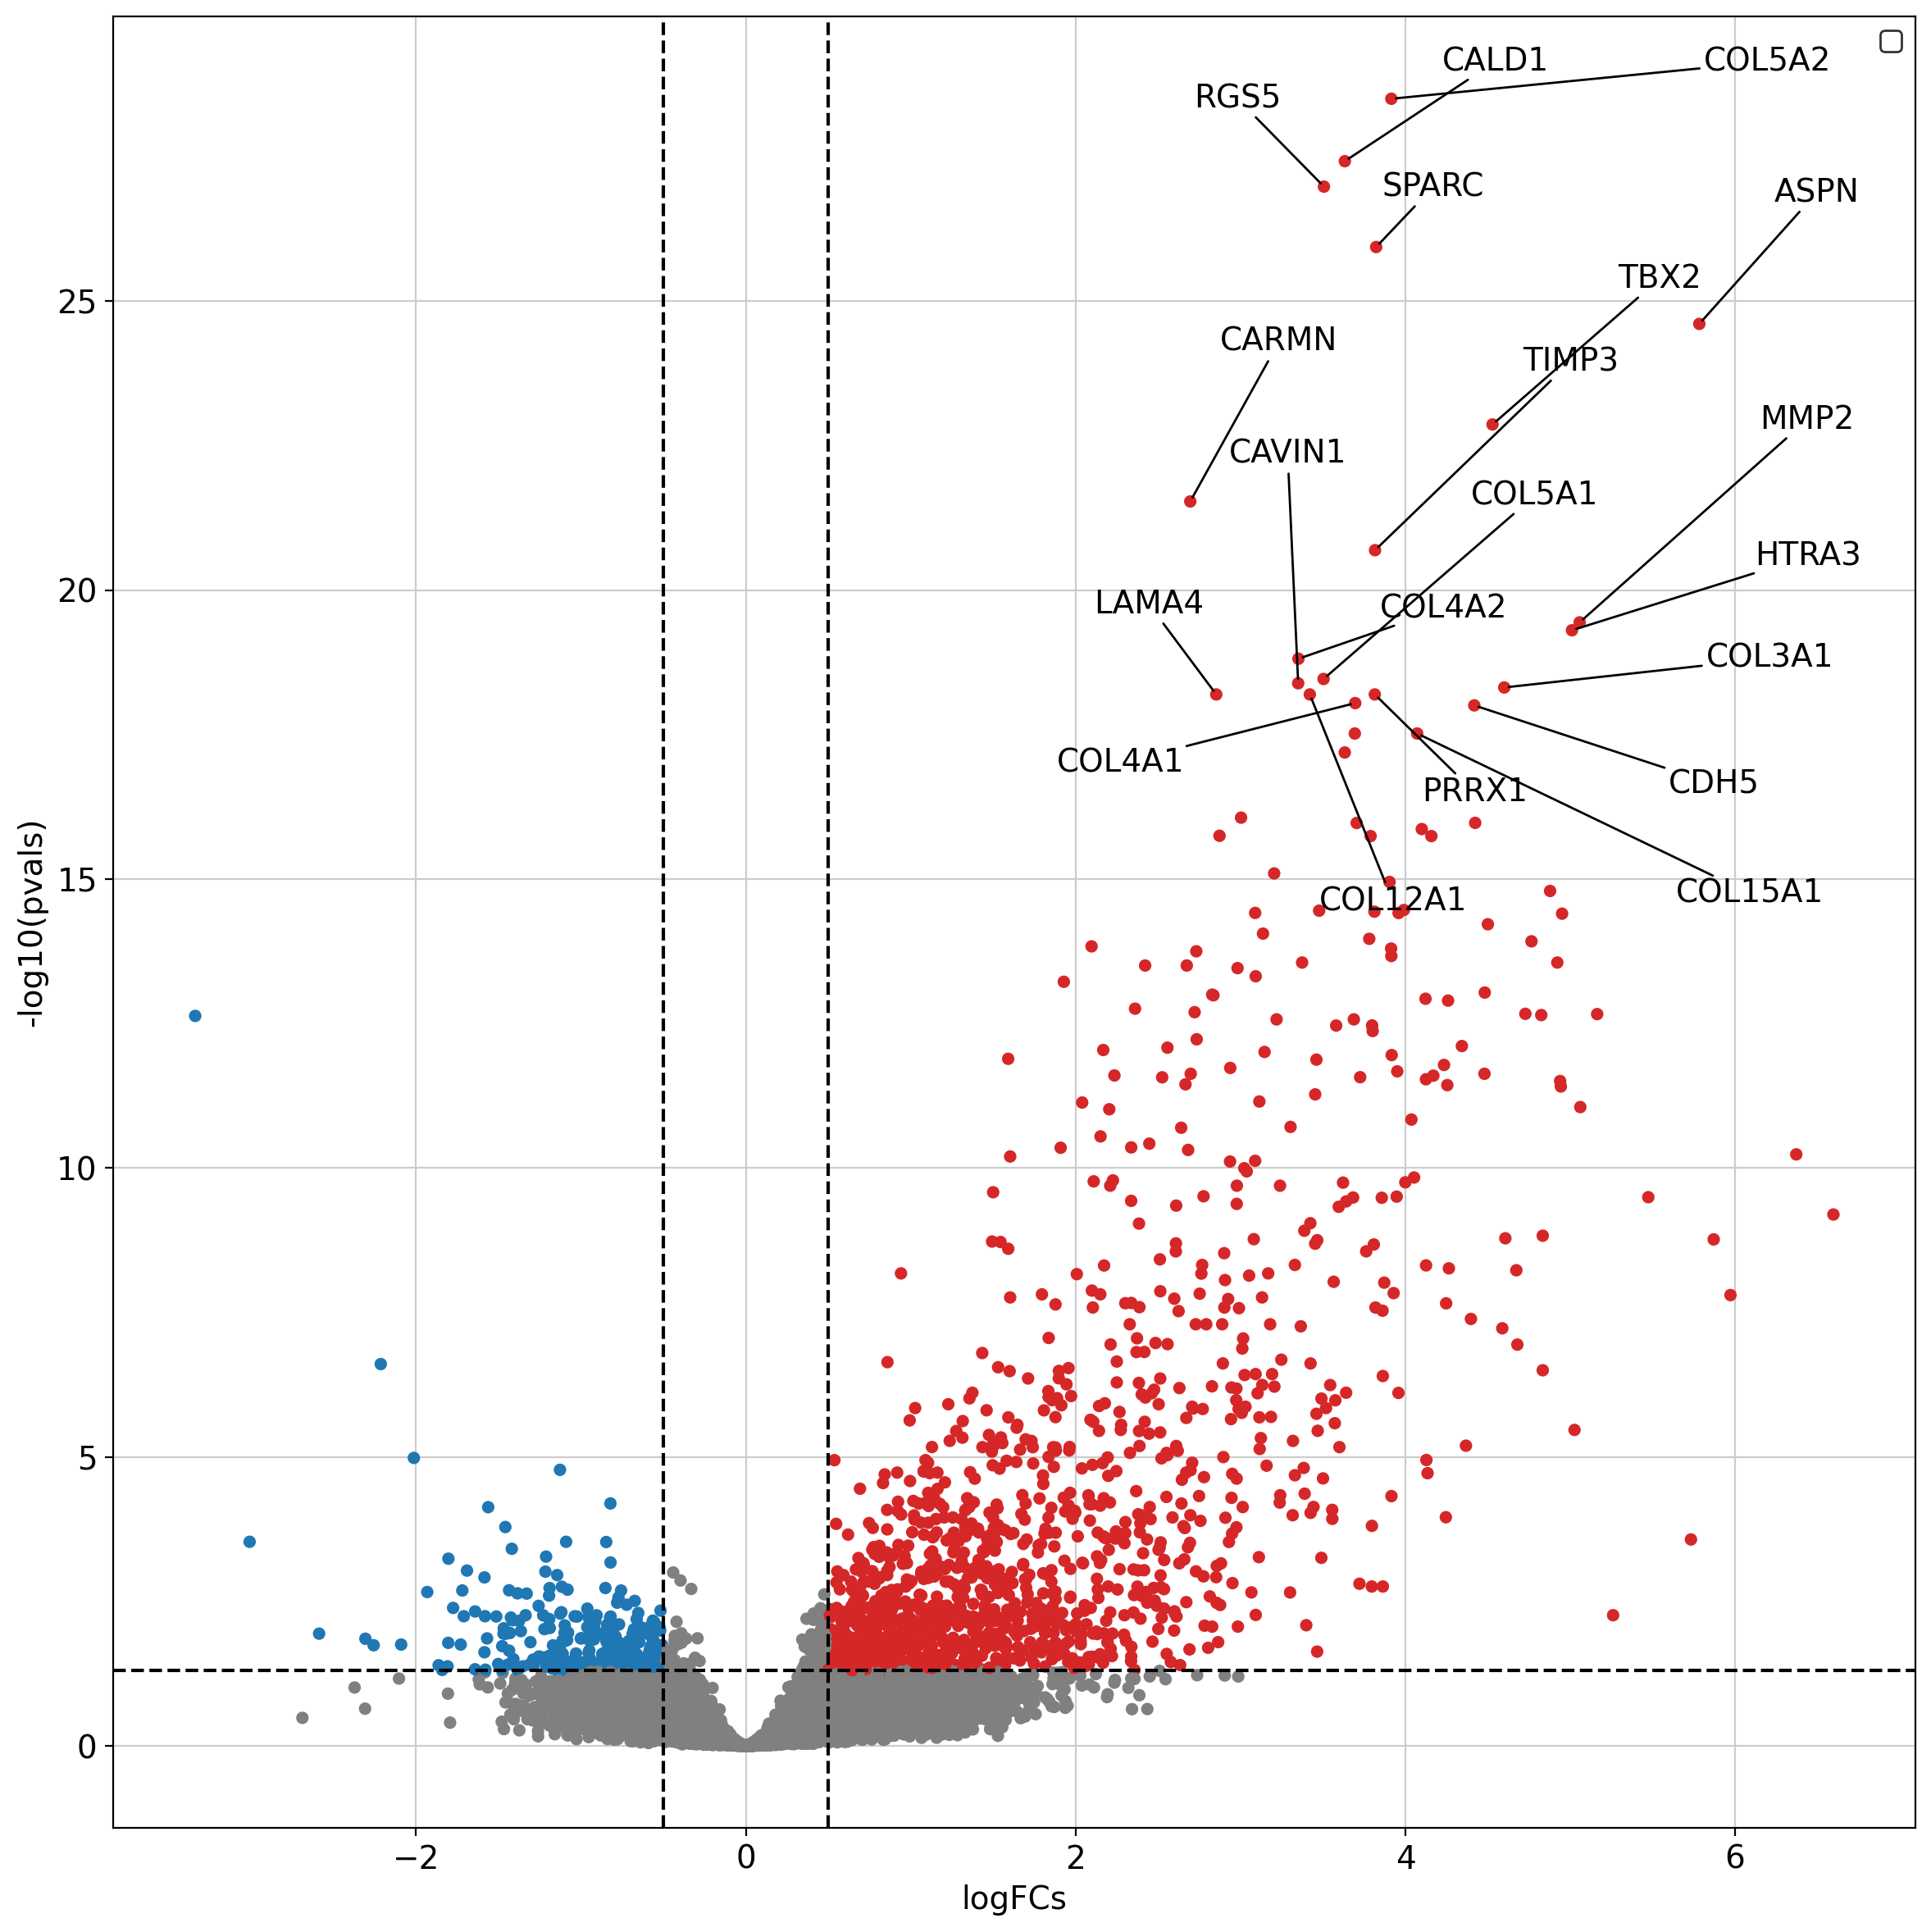

In [18]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
    )
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 12)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

After performing DEA, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used,
but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value.
We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by `decoupler`:

In [19]:
mat = results_df[['stat']].T.rename(index={'stat': 'Lung.vs.LymphNode'})
mat

TSPAN6      DPM1     SCYL3  C1orf112       FGR       CFH  \
Lung.vs.LymphNode  0.510409 -3.350035 -0.723524  1.011882  2.334571  3.566941   

                      FUCA2      GCLC      NFYA     STPG1  ...  \
Lung.vs.LymphNode  1.592982  0.769151  2.009626  0.492182  ...   

                   ENSG00000291275  ENSG00000291276  ANKRD20A11P-1  \
Lung.vs.LymphNode        -1.499804        -2.070219       0.400443   

                   ENSG00000291282  ENSG00000291283  ENSG00000291288  \
Lung.vs.LymphNode         1.448278        -1.255188        -2.385142   

                   ENSG00000291290  ENSG00000291299  ENSG00000291313   TMEM276  
Lung.vs.LymphNode        -2.100072         0.026996        -0.751064  0.276315  

[1 rows x 23219 columns]

# Transcription factor activity inference

The first functional analysis we can perform is to infer transcription factor (TF) activities from our transcriptomics data. We will need a gene regulatory network (GRN) and a statistical method.

### CollecTRI network
[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource
containing a curated collection of TFs and their transcriptional targets
compiled from 12 different resources. This collection provides an increased
coverage of transcription factors and a superior performance in identifying
perturbed TFs compared to our previous
[DoRothEA](https://saezlab.github.io/dorothea/) network and other literature
based GRNs. Similar to DoRothEA, interactions are weighted by their mode of
regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also
available). We can use `decoupler` to retrieve it from `omnipath`. The argument
`split_complexes` keeps complexes or splits them into subunits, by default we
recommend to keep complexes together.

<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). 

</div> 

In [21]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

### Activity inference with Univariate Linear Model (ULM)

To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression
based solely on the TF's TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

<img src="../ulm.png" />

We can run `ulm` with a one-liner:

In [22]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts 	

Running ulm on mat with 1 samples and 23219 targets for 701 sources.


ABL1       AHR      AHRR       AIP      AIRE  \
Lung.vs.LymphNode -0.272535  4.693959 -1.958587  0.412649  1.851745   

                         AP1     APEX1        AR    ARID1A    ARID3A  ...  \
Lung.vs.LymphNode  11.203584  1.173592  7.515489  0.836594 -0.849808  ...   

                     ZNF362    ZNF382    ZNF384    ZNF395    ZNF436    ZNF699  \
Lung.vs.LymphNode  2.957221 -1.170319  4.424486  0.289466 -2.052598  2.176449   

                      ZNF76   ZNF804A     ZNF91      ZXDC  
Lung.vs.LymphNode  0.231242 -0.275438  4.088609  2.218354  

[1 rows x 701 columns]

Let us plot the obtained scores for the top active/inactive transcription factors:

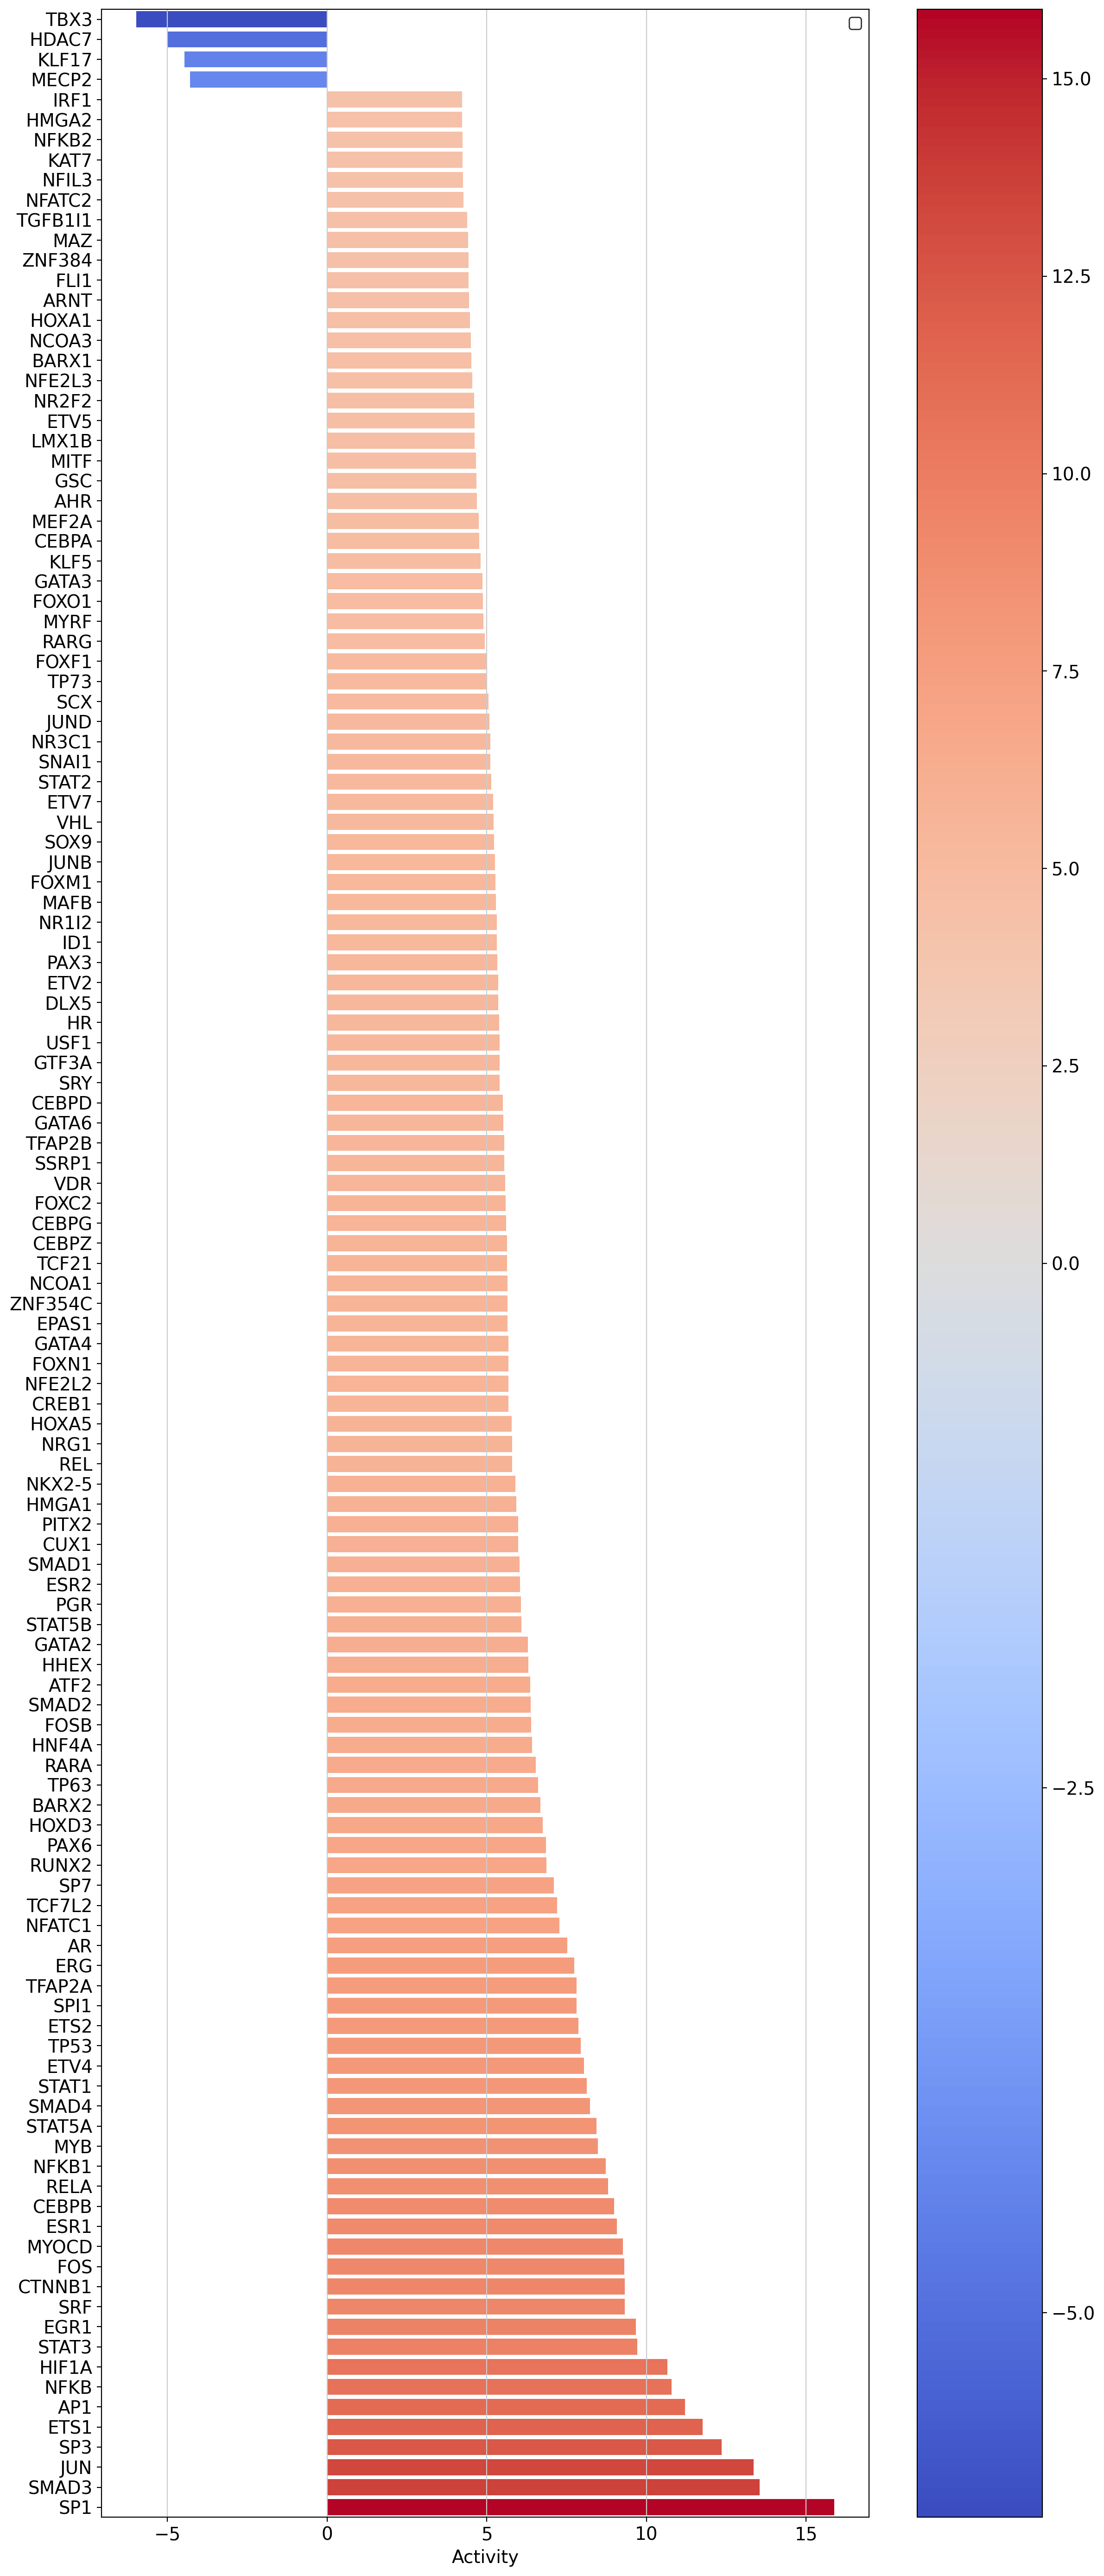

In [23]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_barplot(
		acts=tf_acts,
		contrast='Lung.vs.LymphNode',
		top=125,
		vertical=True,
	)
		
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 28)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

MYOCD SRF and JUNB seem to be the most activated in this treatment while IRF1, KLF11 AND ARID1A seem to be inactivated.

We can also plot the network of interesting TFs (top and bottom by activity) and color the nodes by activity and target gene expression:

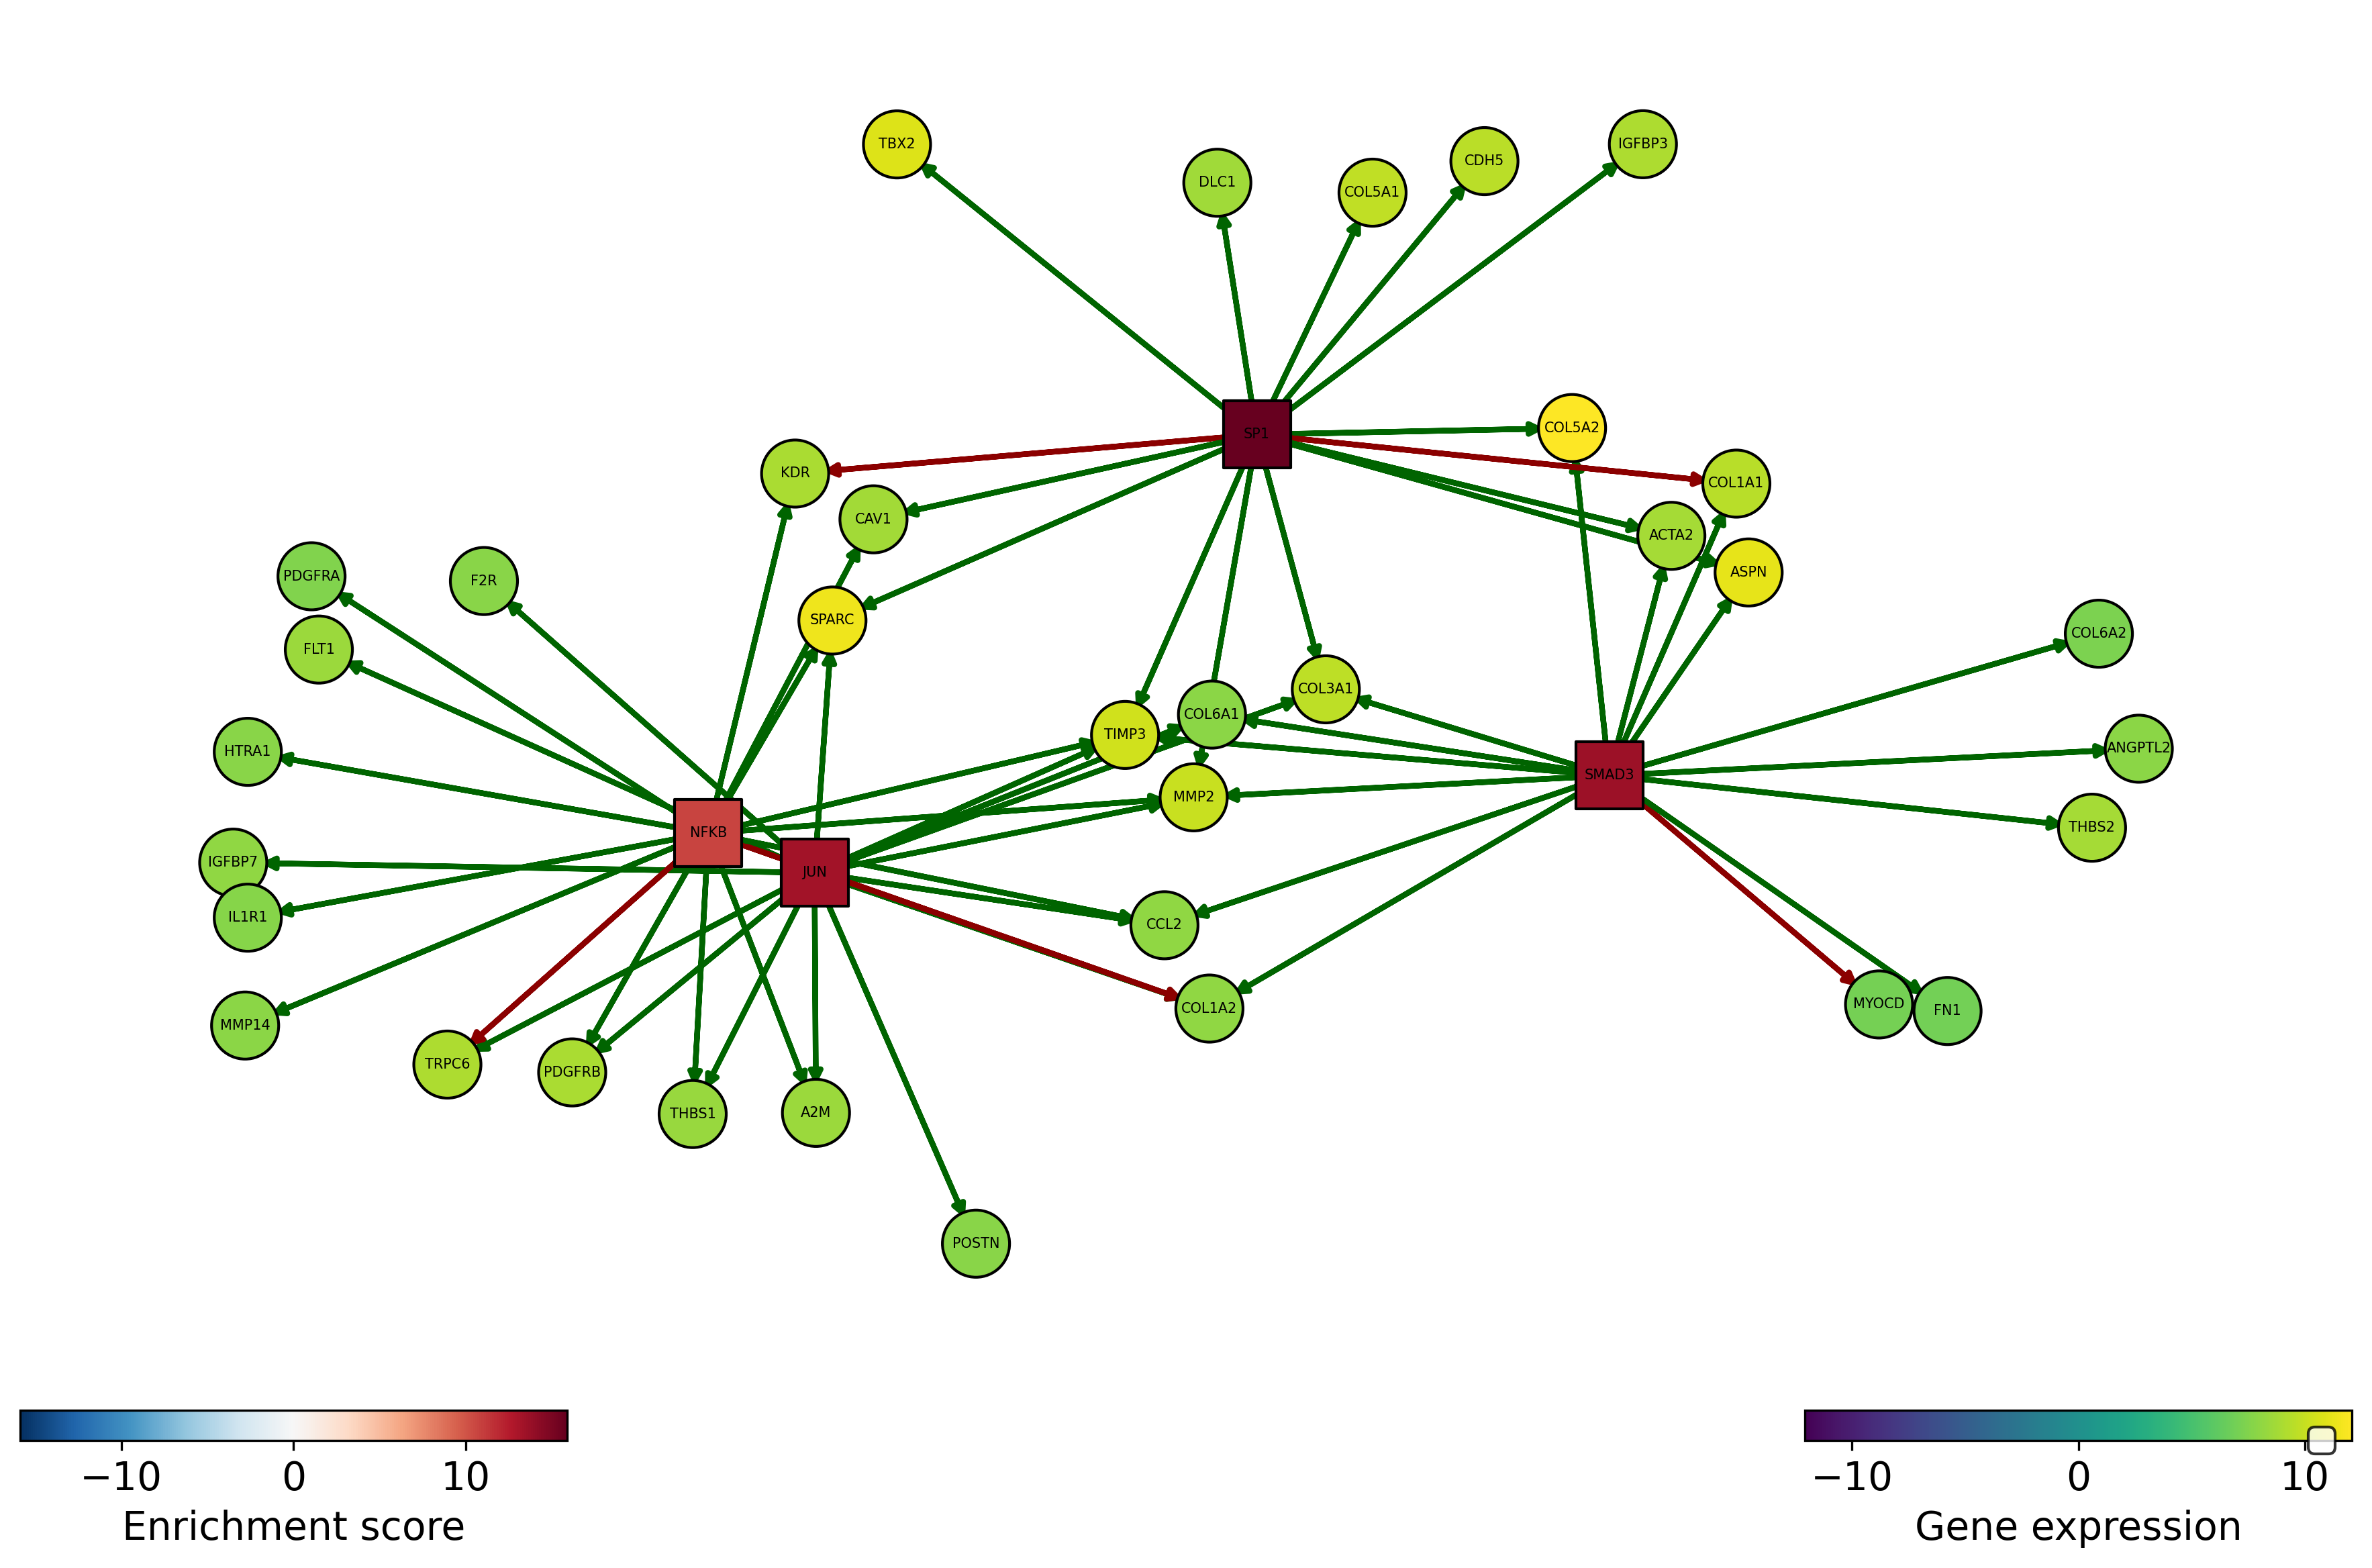

In [24]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_network(
		net=collectri,
		obs=mat,
		act=tf_acts,
		n_sources=['SP1', 'SMAD3', 'JUN', 'NFKB'],
		n_targets=15,
		node_size=100,
		figsize=(10, 10),
		c_pos_w='darkgreen',
		c_neg_w='darkred',
		vcenter=True
	)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

SRF seems to be active in treated cells since their positive targets are up-regulated.

If needed, we can also look at a volcano plot of the target genes:

In [25]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'Lung.vs.LymphNode'})
pvals = results_df[['padj']].T.rename(index={'padj': 'Lung.vs.LymphNode'})

# Plot


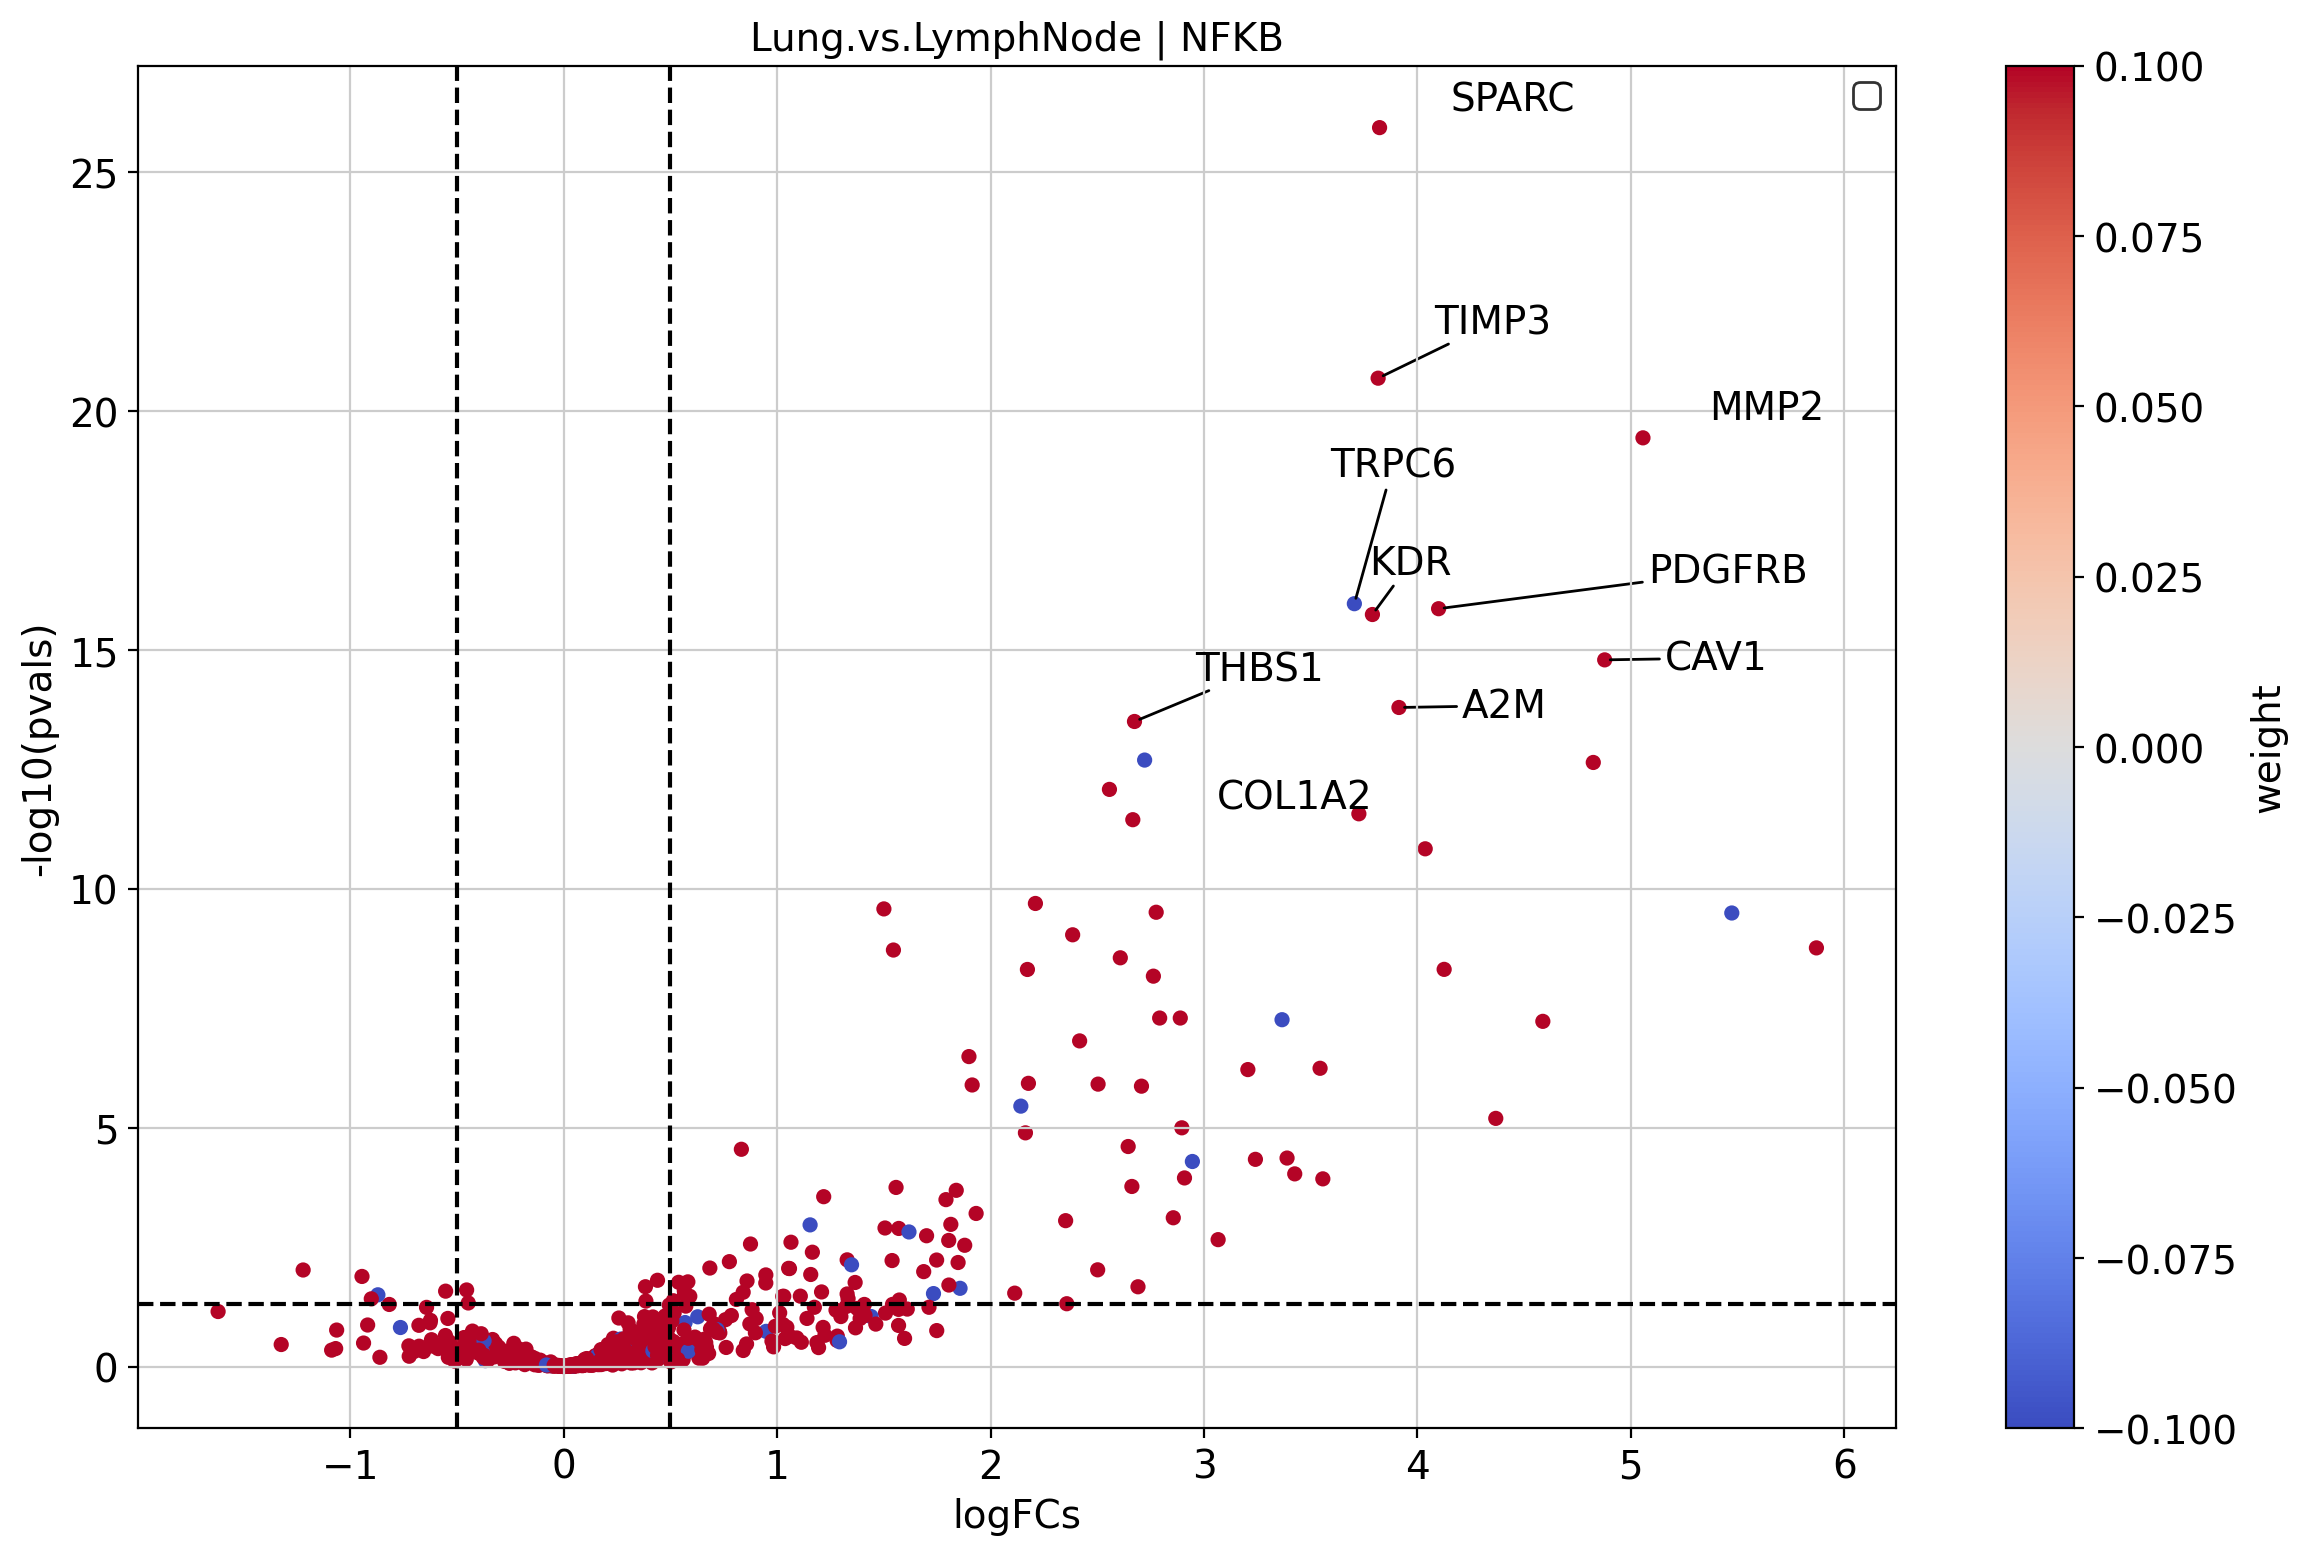

In [26]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_volcano(
        logFCs,
        pvals,
        'Lung.vs.LymphNode',
        name='NFKB',
        net=collectri,
        top=10,
        sign_thr=0.05,
        lFCs_thr=0.5
    )
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Pathway activity inference

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

### PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- **Androgen**: involved in the growth and development of the male reproductive organs.
- **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- **Estrogen**: promotes the growth and development of the female reproductive organs.
- **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.
- **MAPK**: integrates external signals and promotes cell growth and proliferation.
- **NFkB**: regulates immune response, cytokine production and cell survival.
- **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- **PI3K**: promotes growth and proliferation.
- **TGFb**: involved in development, homeostasis, and repair of most tissues.
- **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- **Trail**: induces apoptosis.
- **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.
- **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [27]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

source   target     weight       p_value
0     Androgen  TMPRSS2  11.490631  0.000000e+00
1     Androgen   NKX3-1  10.622551  2.242078e-44
2     Androgen   MBOAT2  10.472733  4.624285e-44
3     Androgen     KLK2  10.176186  1.944414e-40
4     Androgen     SARG  11.386852  2.790209e-40
...        ...      ...        ...           ...
6995       p53    ZMYM4  -2.325752  1.522388e-06
6996       p53    CFDP1  -1.628168  1.526045e-06
6997       p53   VPS37D   2.309503  1.537098e-06
6998       p53    TEDC1  -2.274823  1.547037e-06
6999       p53  CCDC138  -3.205113  1.568160e-06

[7000 rows x 4 columns]

### Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways' Pathway-Gene interactions weights.
Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

<img src="../mlm.png" />
     
We can run `mlm` with a one-liner:

In [28]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny, verbose=True)
pathway_acts

Running mlm on mat with 1 samples and 23219 targets for 14 sources.


Androgen      EGFR  Estrogen  Hypoxia  JAK-STAT      MAPK  \
Lung.vs.LymphNode  4.885453  0.500617  1.154012  0.13278    6.6437  0.982684   

                       NFkB      PI3K       TGFb      TNFa    Trail      VEGF  \
Lung.vs.LymphNode  0.369918  1.468549  14.149863  4.829954  0.73279  1.755929   

                        WNT       p53  
Lung.vs.LymphNode  2.536787  2.829577

Let us plot the obtained scores:

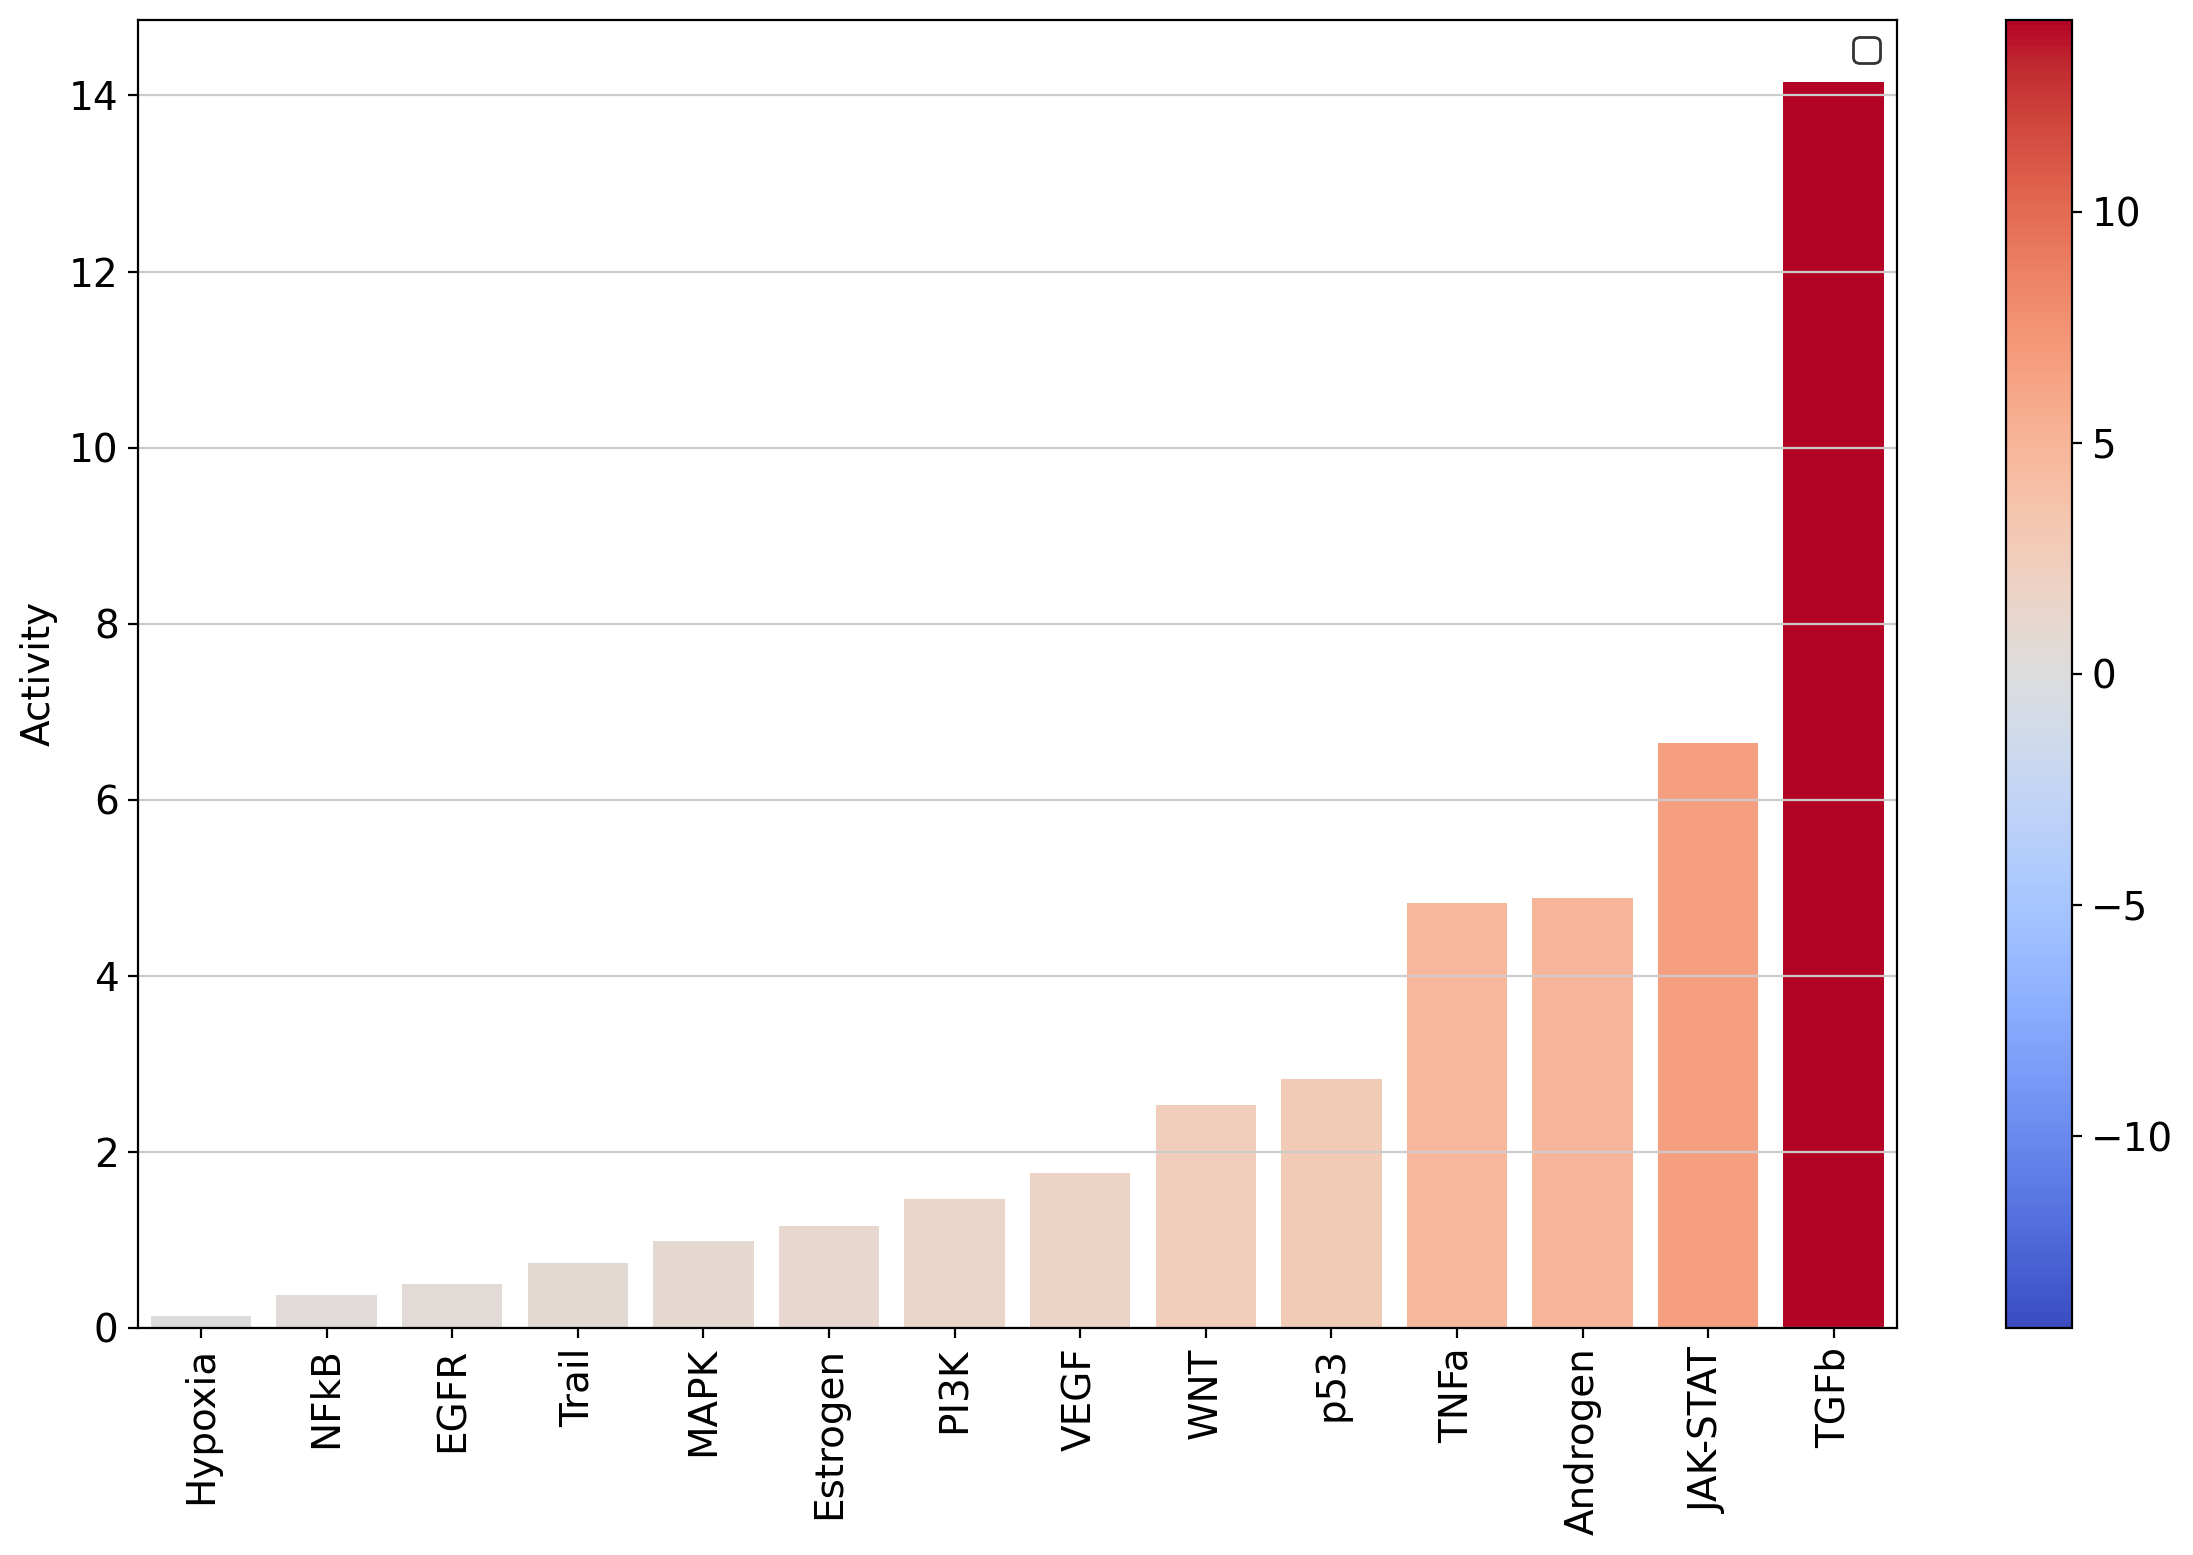

In [29]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_barplot(
		pathway_acts,
		'Lung.vs.LymphNode',
		top=25,
		vertical=False,
	)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

As expected, after treating cells with the cytokine TGFb we see an increase of activity for this pathway.

On the other hand, it seems that this treatment has decreased the activity of other pathways like JAK-STAT or TNFa.

We can visualize the targets of TFGb in a scatter plot:

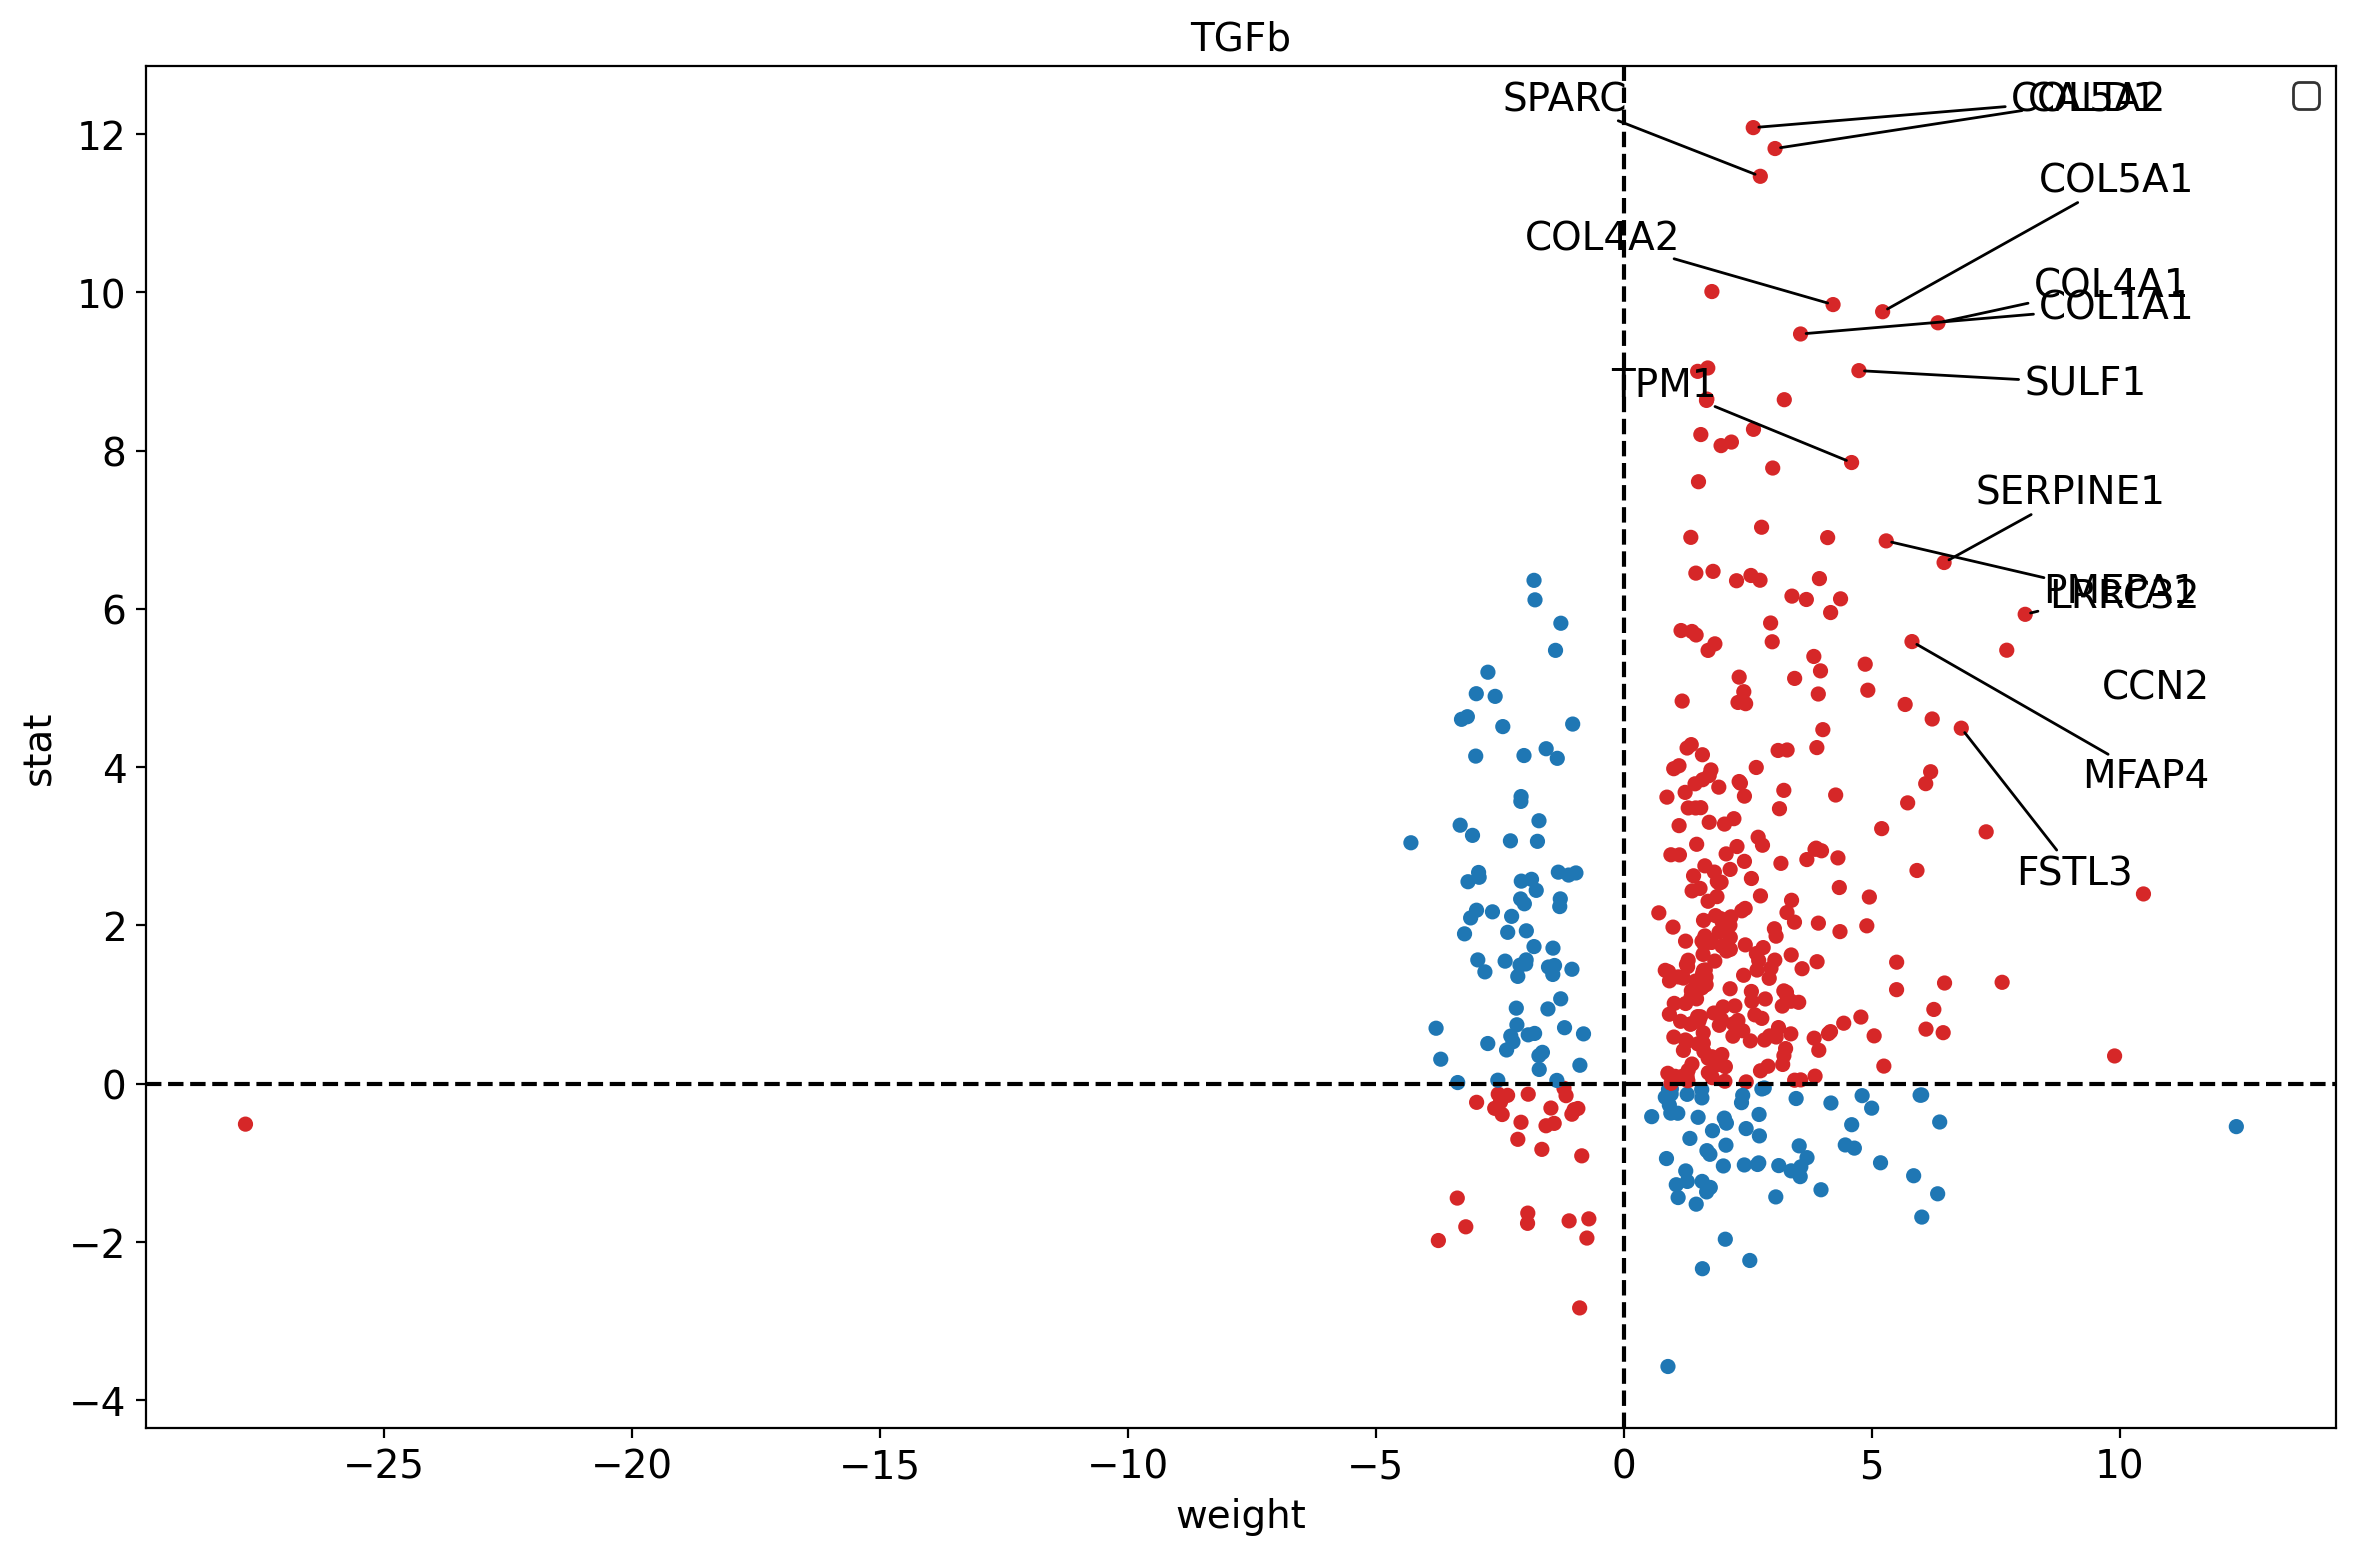

In [30]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_targets(results_df, stat='stat', source_name='TGFb', net=progeny, top=15)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

The observed activation of TGFb is due to the fact that majority of its target genes with positive weights have positive
t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).

# Functional enrichment of biological terms

Finally, we can also infer activities for general biological terms or processes.

### MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [31]:
msigdb = dc.get_resource('MSigDB')
msigdb

genesymbol                          collection  \
0             MAFF  chemical_and_genetic_perturbations   
1             MAFF  chemical_and_genetic_perturbations   
2             MAFF  chemical_and_genetic_perturbations   
3             MAFF                         immunesigdb   
4             MAFF  chemical_and_genetic_perturbations   
...            ...                                 ...   
3838543   PRAMEF22               go_biological_process   
3838544   PRAMEF22               go_biological_process   
3838545   PRAMEF22               go_biological_process   
3838546   PRAMEF22               go_biological_process   
3838547   PRAMEF22               go_biological_process   

                                                   geneset  
0                     BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN  
1                                       ELVIDGE_HYPOXIA_UP  
2                                 NUYTTEN_NIPP1_TARGETS_DN  
3                GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN  
4                   SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP  
...                                                    ...  
3838543  GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...  
3838544                             GOBP_APOPTOTIC_PROCESS  
3838545                      GOBP_REGULATION_OF_CELL_DEATH  
3838546  GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547             GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH  

[3838548 rows x 3 columns]

As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [32]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

msigdb

genesymbol collection                  geneset
233           MAFF   hallmark      IL2_STAT5_SIGNALING
250           MAFF   hallmark              COAGULATION
270           MAFF   hallmark                  HYPOXIA
373           MAFF   hallmark  TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               COMPLEMENT
...            ...        ...                      ...
1449668     STXBP1   hallmark      PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      PANCREAS_BETA_CELLS
1450526        GCG   hallmark      PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

### Enrichment with Over Representation Analysis (ORA)

To infer functional enrichment scores we will run the Over Representation Analysis (`ora`) method.
As input data it accepts an expression matrix (`decoupler.run_ora`) or the results of differential expression analysis (`decoupler.run_ora_df`).
For the former, by default the top 5% of expressed genes by sample are selected as the set of interest (S*), and for the latter a user-defined
significance filtering can be used.
Once we have S*, it builds a contingency table using set operations for each set stored in the gene set resource being used (`net`).
Using the contingency table, `ora` performs a one-sided Fisher exact test to test for significance of overlap between sets.
The final score is obtained by log-transforming the obtained p-values, meaning that higher values are more significant.

<img src="../ora.png" />
     
We can run `ora` with a simple one-liner:

In [33]:
# Infer enrichment with ora using significant deg
top_genes = results_df[results_df['padj'] < 0.05]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()

Term  Set size  Overlap ratio       p-value   FDR p-value  \
0         ADIPOGENESIS       200       0.105000  1.527102e-01  2.580275e-01   
1  ALLOGRAFT_REJECTION       200       0.140000  4.142775e-03  1.068400e-02   
2    ANDROGEN_RESPONSE       100       0.270000  2.392153e-08  1.065595e-07   
3         ANGIOGENESIS        36       0.444444  6.539722e-09  3.204464e-08   
4      APICAL_JUNCTION       200       0.245000  2.820192e-12  2.763788e-11   

   Odds ratio  Combined score  \
0    1.300610        2.444124   
1    1.731489        9.499621   
2    3.347931       58.751131   
3    5.511480      103.865880   
4    3.046683       81.024145   

                                            Features  
0  ABCA1;C3;CAVIN1;CAVIN2;CD302;COL15A1;COL4A1;FZ...  
1  B2M;BCAT1;CAPG;CCL2;CCND2;CCR5;CSF1;CSK;CXCL9;...  
2  ACTN1;ADAMTS1;AKAP12;ALDH1A3;ARID5B;B2M;B4GALT...  
3  CCND2;COL3A1;COL5A2;CXCL6;FSTL1;ITGAV;JAG1;KCN...  
4  ACTB;ACTG2;ACTN1;ADAMTS5;B4GALT1;BMP1;CAP1;CD2...

Then we can visualize the most enriched terms:

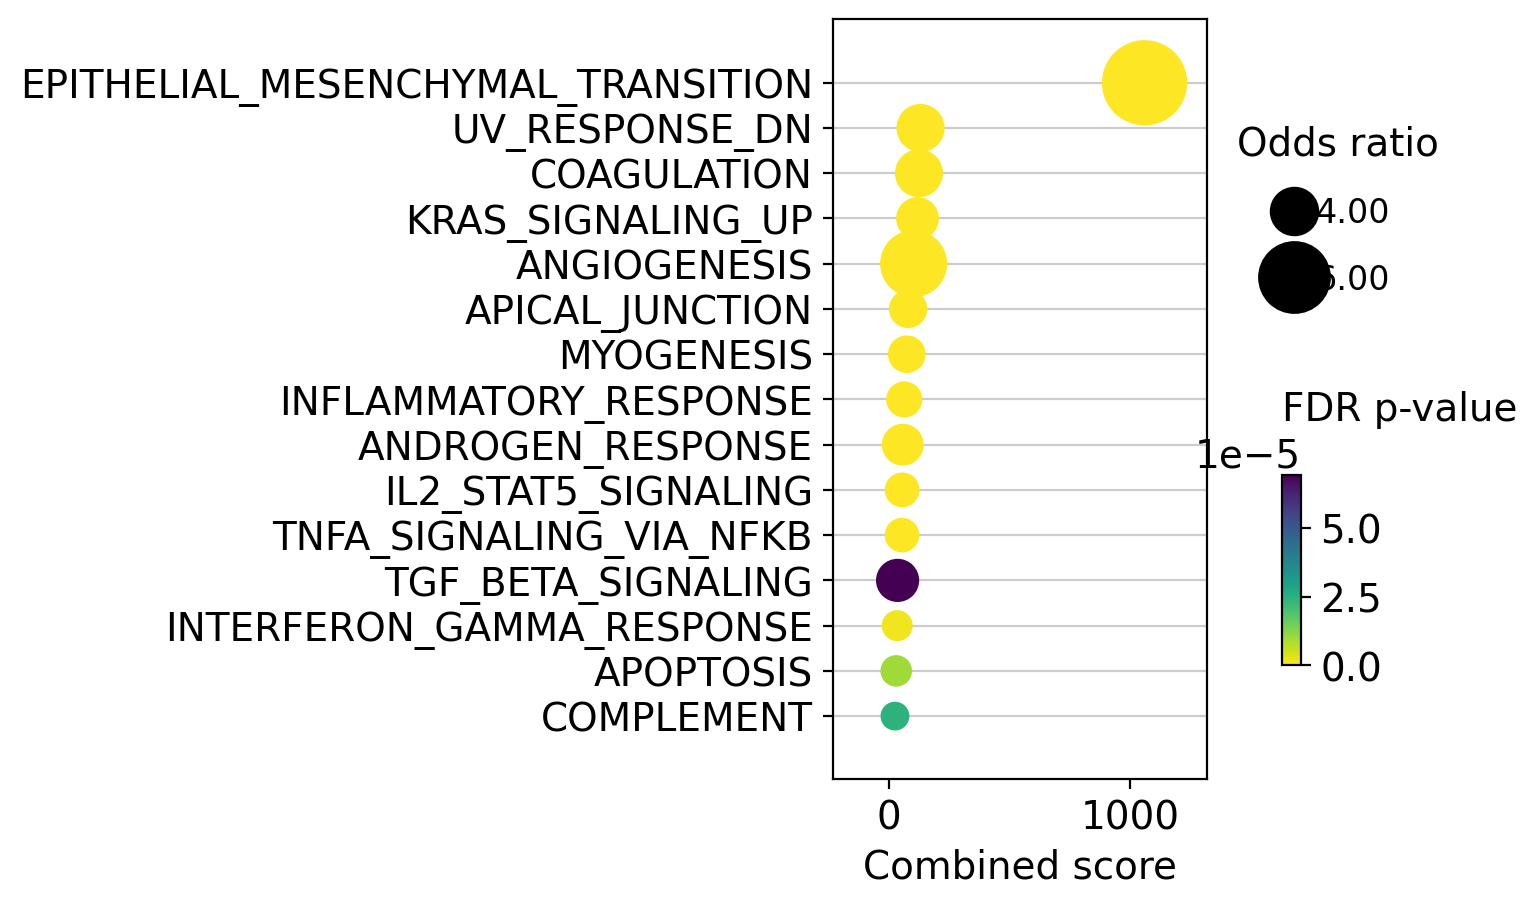

In [34]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.7,
)

TNFa and interferons response (JAK-STAT) processes seem to be enriched. We previously observed a similar result with the PROGENy pathways, were they were significantly downregulated. Therefore, one of the limitations of using a prior knowledge resource without weights is that it doesn't provide direction.

We can also plot the running score for a given gene set:

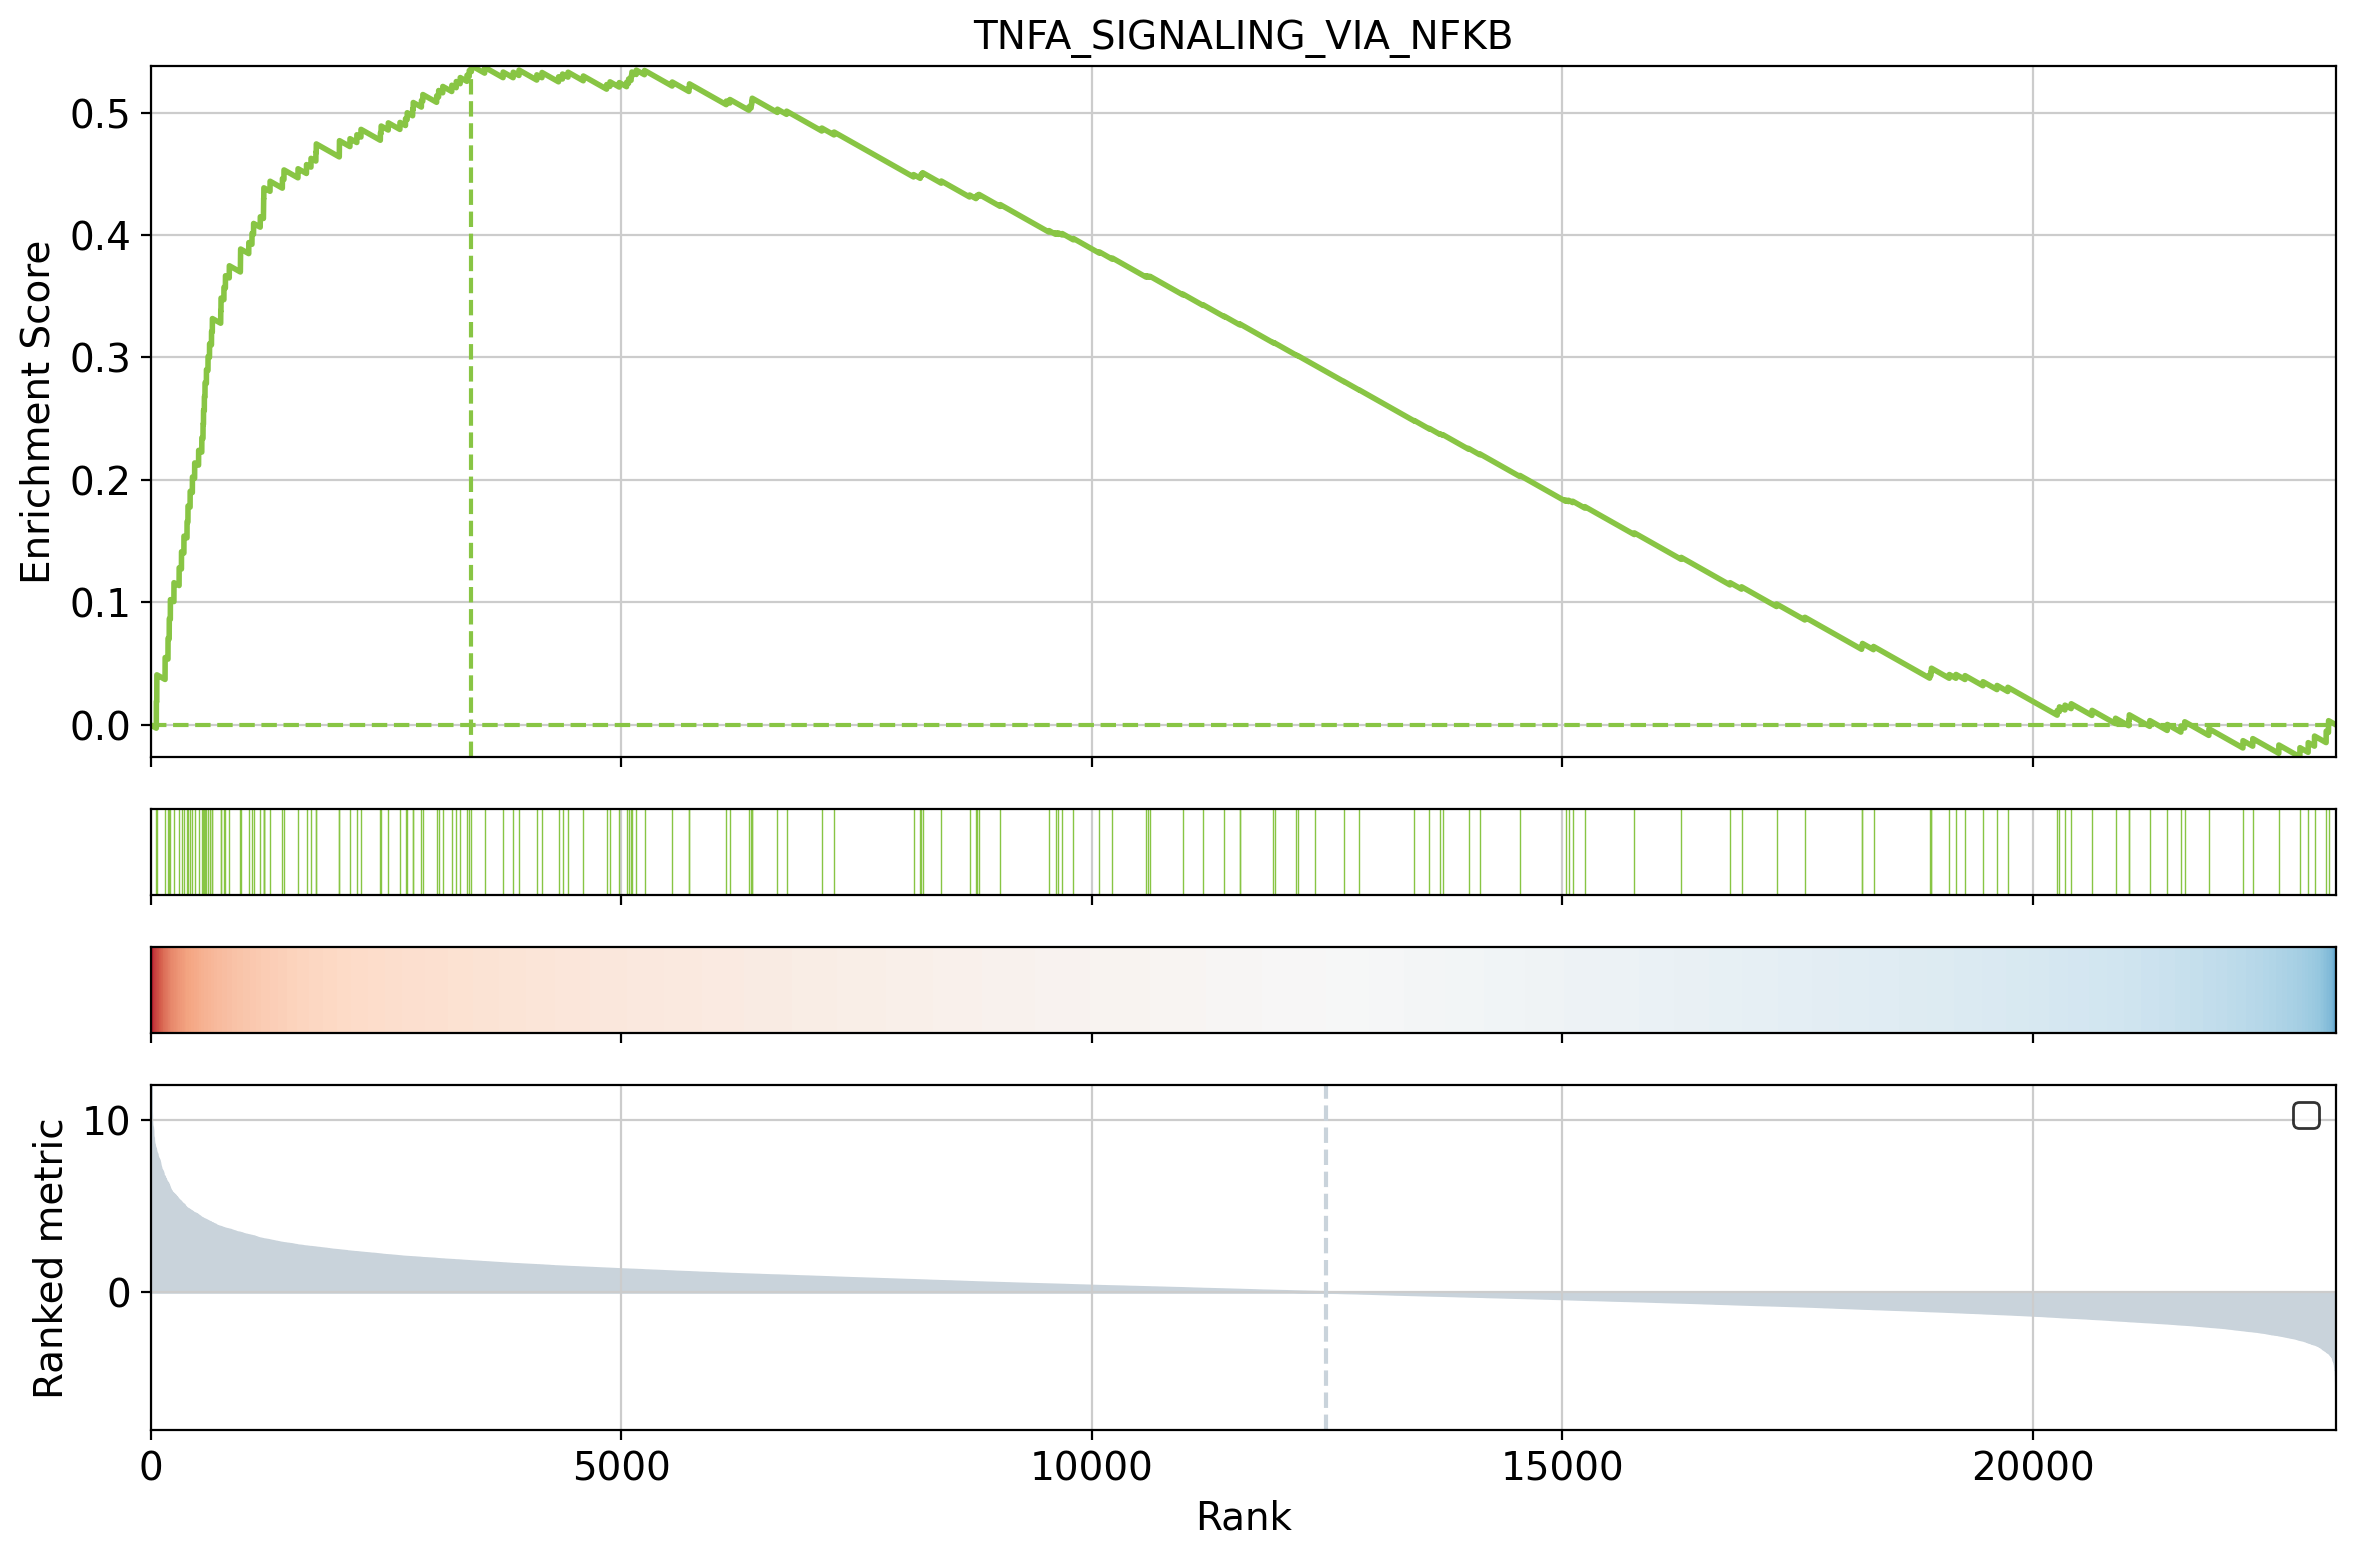

In [35]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_running_score(
		df=results_df,
		stat='stat',
		net=msigdb,
		source='geneset',
		target='genesymbol',
		set_name='TNFA_SIGNALING_VIA_NFKB'
	)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

## Enrichment of ligand-receptor interactions

Recently, study of interactions between ligands and receptors have gained significant traction, notably pushed by the democratization of single cell sequencing technologies. While most methods (such as the one described in LIANA) are developed for single cell datasets, they rely on a relatively simple assumption of co-expression or co-regulation of two (or more in the context of complexes) genes acting as ligand and receptors to propose hypothetical ligand-receptor interaction events. This concept can seamlessly be applied to a bulk RNA dataset, where the assumption is that sender and receiver cells are convoluted in a single dataset, but the observation of significant co-regulation of ligand and receptors should still correspond to hypothetical ligand-receptor interaction events.

At the core, most current ligand-receptor interaction methods rely on averaging the measurements obtained for ligand and receptor and standardizing them against a background distribution.  Thus, an enrichment method based on a weighted mean can emulate this, where the sets are simply the members of a ligand receptor pair (or more in the context of complexes).

Thus, we can extract ligand-receptor interaction ressources from the LIANA package (available both in [R](https://saezlab.github.io/liana/) and [python](https://liana-py.readthedocs.io/en/latest/)), and use it as a prior knowledge network with decoupler to find the most significant pairs of ligand-receptors in a given bulk dataset.

While more work is required to fully understand the functional relevance of the highlighted ligand-receptor interactions with such an approach, this represents a very straightforward and intuitive approach to embed a bulk RNA dataset with ligand-receptor interaction prior knowledge.


First, we extract ligand-receptor interactions from liana, and decomplexify them to format them into an appropriate decoupleR input.

In [36]:
import liana as ln

liana_lr = ln.resource.select_resource()
liana_lr = ln.resource.explode_complexes(liana_lr)

# Create two new DataFrames, each containing one of the pairs of columns to be concatenated
df1 = liana_lr[['interaction', 'ligand']]
df2 = liana_lr[['interaction', 'receptor']]

# Rename the columns in each new DataFrame
df1.columns = ['interaction', 'genes']
df2.columns = ['interaction', 'genes']

# Concatenate the two new DataFrames
liana_lr = pd.concat([df1, df2], axis=0)
liana_lr['weight'] = 1

# Find duplicated rows
duplicates = liana_lr.duplicated()

# Remove duplicated rows
liana_lr = liana_lr[~duplicates]

liana_lr

interaction   genes  weight
0     LGALS9&PTPRC  LGALS9       1
1       LGALS9&MET  LGALS9       1
2      LGALS9&CD44  LGALS9       1
3      LGALS9&LRP1  LGALS9       1
4      LGALS9&CD47  LGALS9       1
...            ...     ...     ...
5775    BMP2&ACTR2   ACTR2       1
5776   BMP15&ACTR2   ACTR2       1
5777    CSF1&CSF3R   CSF3R       1
5778  IL36G&IFNAR1  IFNAR1       1
5779  IL36G&IFNAR2  IFNAR2       1

[10381 rows x 3 columns]

In [37]:
"ASCL1" in liana_lr["genes"]

False

In [38]:
# Choose ROI and add guides on the external of the slice

Then we can use `ulm` to find the significant co-regulated pairs of ligand and receptors.

In [39]:
mat

TSPAN6      DPM1     SCYL3  C1orf112       FGR       CFH  \
Lung.vs.LymphNode  0.510409 -3.350035 -0.723524  1.011882  2.334571  3.566941   

                      FUCA2      GCLC      NFYA     STPG1  ...  \
Lung.vs.LymphNode  1.592982  0.769151  2.009626  0.492182  ...   

                   ENSG00000291275  ENSG00000291276  ANKRD20A11P-1  \
Lung.vs.LymphNode        -1.499804        -2.070219       0.400443   

                   ENSG00000291282  ENSG00000291283  ENSG00000291288  \
Lung.vs.LymphNode         1.448278        -1.255188        -2.385142   

                   ENSG00000291290  ENSG00000291299  ENSG00000291313   TMEM276  
Lung.vs.LymphNode        -2.100072         0.026996        -0.751064  0.276315  

[1 rows x 23219 columns]

In [40]:
# Infer lr activities with ulm
lr_score, lr_pvalue = dc.run_ulm(
    mat=mat,
    net=liana_lr,
    source='interaction',
    target='genes',
    min_n=2,
    verbose=True
)

Running ulm on mat with 1 samples and 23219 targets for 3082 sources.


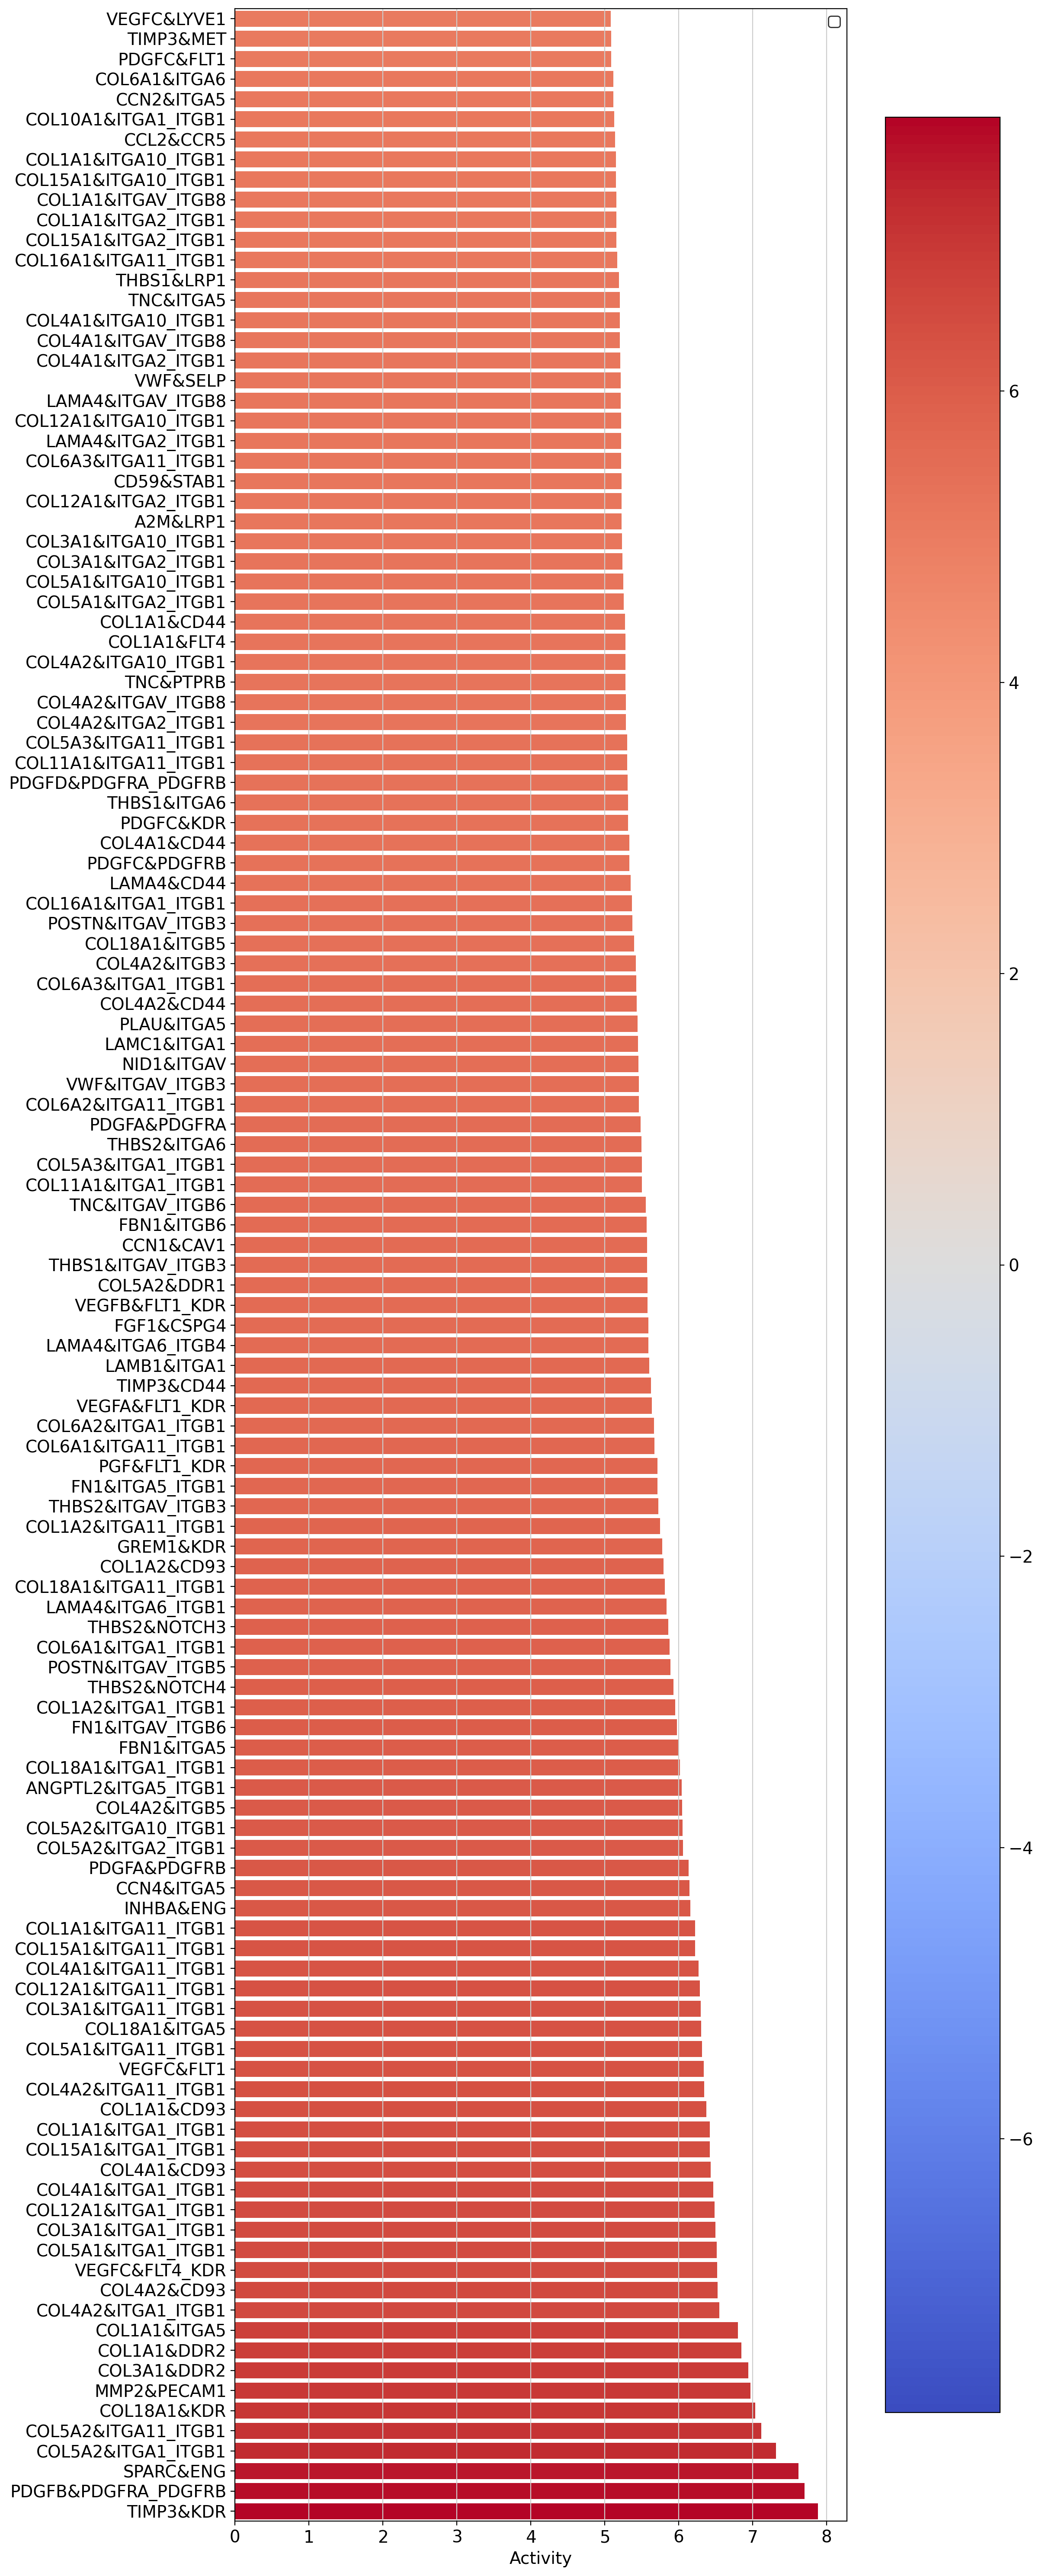

In [41]:
# Use rc_context to temporarily set the figure size
with plt.rc_context():
    plot_func = dc.plot_barplot(acts=lr_score, contrast='Lung.vs.LymphNode', top=125, vertical=True,figsize=(12,30))
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 30)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


Interactions between colagens and the ITG_ITG complexes seems to be quite enrichned. That is especially relevant since the EMT pathway was significantly enriched in the functional pathway analysis.

# TCGA

In [42]:



gdc_sample_sheep='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/gdc_sample_sheet.2024-08-22.tsv'
gdc_download_files='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/gdc_download_20240822_145832.884522'
clinical_cart='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/clinical.cart.2024-08-22'
sclc_tcga=ov.bulk.pyTCGA(gdc_sample_sheep,gdc_download_files,clinical_cart)
sclc_tcga.adata_init()


tcga module init success
...index init


... expression matrix init
...anndata construct


In [43]:
sclc_tcga.adata_meta_init()


...anndata meta init ['gene_name', 'gene_type'] ['Case ID', 'Sample Type']


AnnData object with n_obs × n_vars = 95 × 60664
    obs: 'Case ID', 'Sample Type'
    var: 'gene_name', 'gene_type', 'gene_id'
    layers: 'tpm', 'fpkm', 'deseq_normalize'

In [44]:
sclc_tcga.survial_init()


In [45]:
sclc_tcga.adata

AnnData object with n_obs × n_vars = 95 × 60664
    obs: 'Case ID', 'Sample Type', 'vital_status', 'days'
    var: 'gene_name', 'gene_type', 'gene_id'
    layers: 'tpm', 'fpkm', 'deseq_normalize'

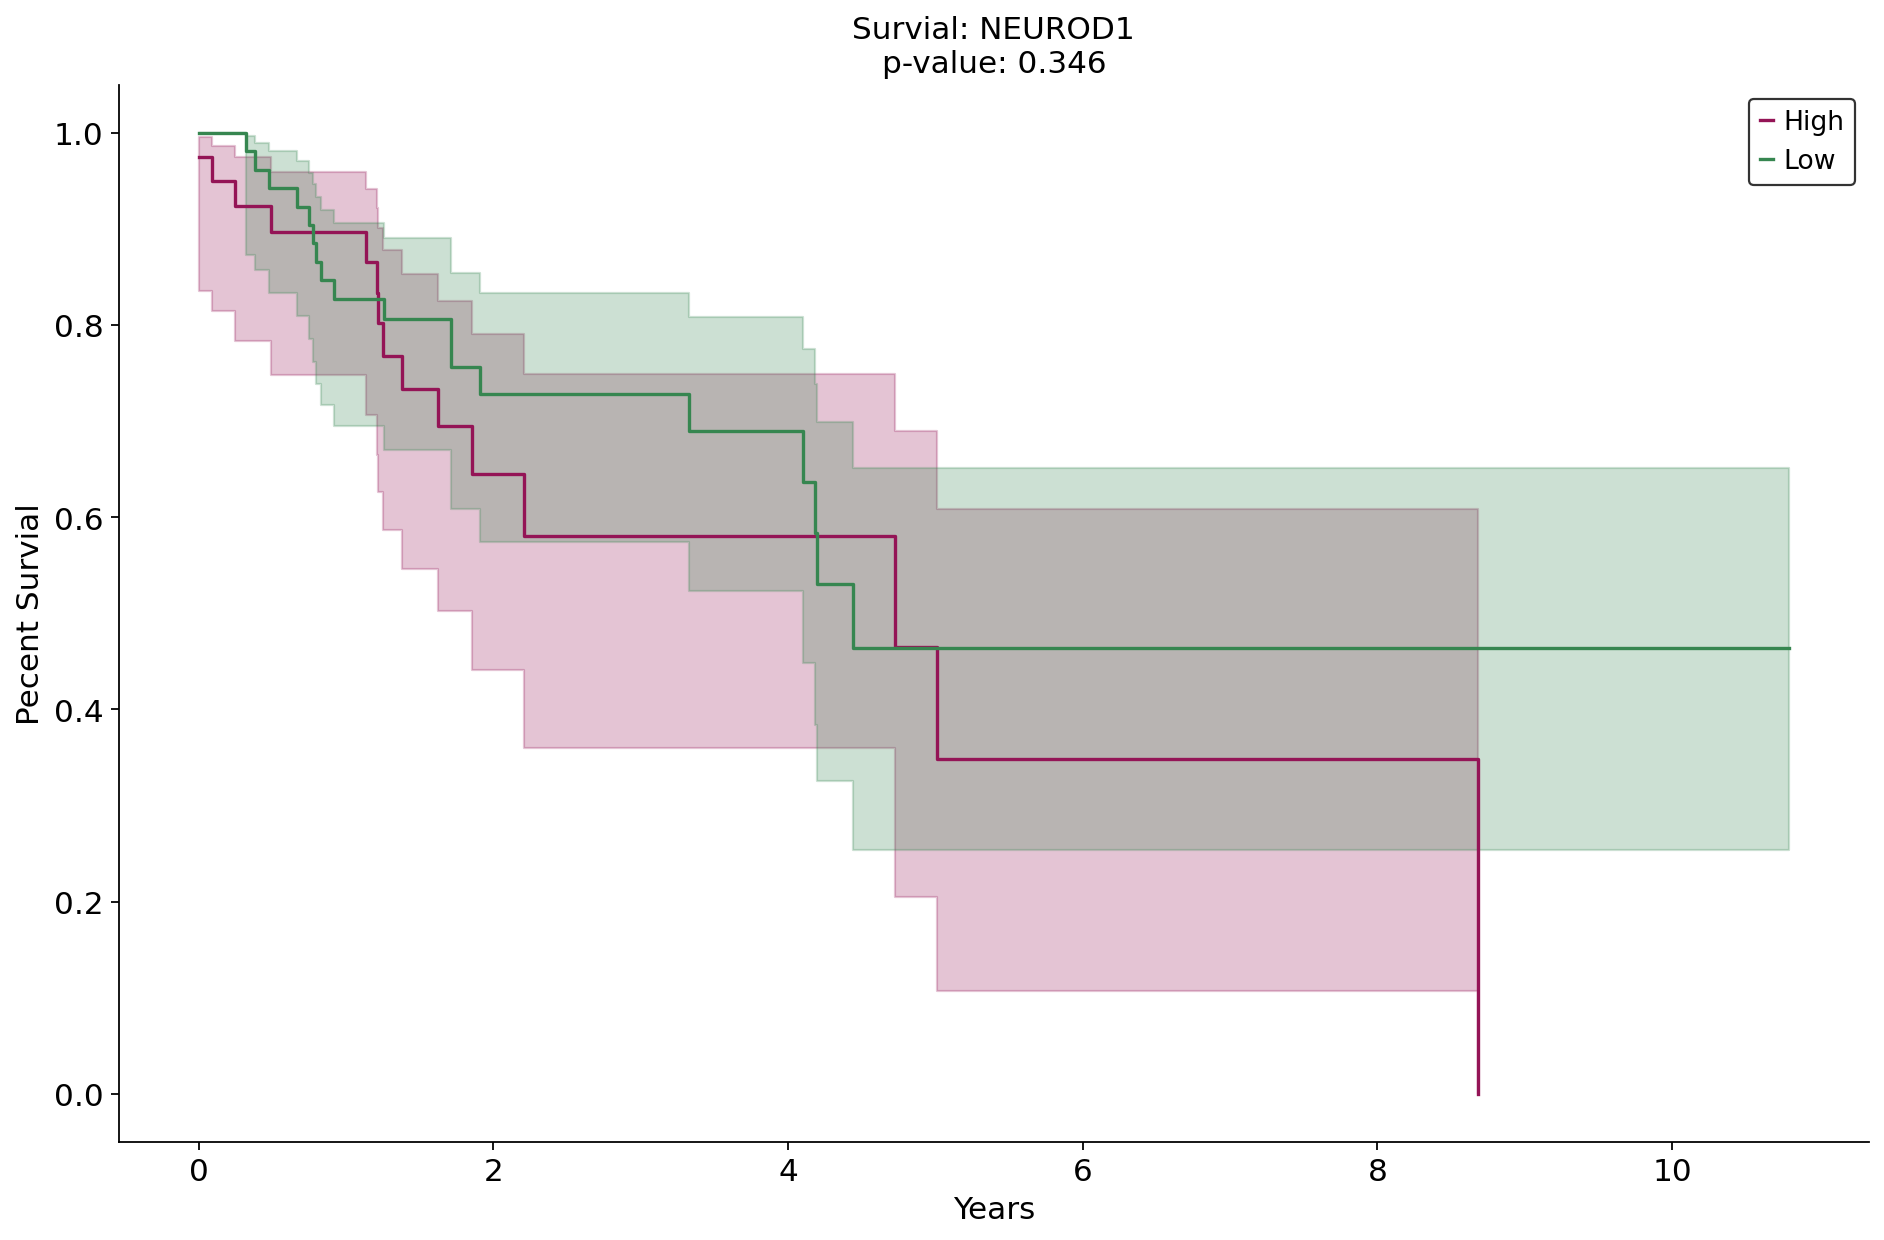

In [46]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = sclc_tcga.survival_analysis('NEUROD1', layer='deseq_normalize', plot=True)
    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


# Bulk 2 Single

In [47]:
count_matrix

R2_07  R2_22  R1_74  R1_19  R2_29  R2_60  R2_35  R2_61  \
TSPAN6             288     48    226     36     57     95    164     85   
DPM1               753    271    226    179    247    211    359    255   
SCYL3              549    113     88     66     30     85    127     45   
C1orf112           956    222    121    311    138     72    322     90   
FGR                 13     14      8    435     18     17      7     21   
...                ...    ...    ...    ...    ...    ...    ...    ...   
ENSG00000291288      7      4      8      0      0      0      0     30   
ENSG00000291290     54     30     16    111      0      0     22      8   
ENSG00000291299    256    130    217    132    292     56    209    180   
ENSG00000291313     18     41      0      0      4      0      0      0   
TMEM276             37     30     25    165     36      0      0      0   

                 R2_10  R1_67  ...  R1_73  R2_23  R2_26  R2_02  R2_08  R2_56  \
TSPAN6              62    223  ...    143    124    213     21     44    143   
DPM1               170    414  ...    393    377    758    210    165    331   
SCYL3               71    183  ...    151    224    231    180     46    127   
C1orf112            90    154  ...    236    331    212     53     33     78   
FGR                  6     69  ...     13      0     36     36      2     52   
...                ...    ...  ...    ...    ...    ...    ...    ...    ...   
ENSG00000291288      8      1  ...     13     17     41      5      5      0   
ENSG00000291290      0     21  ...     11     38     36     32      0     60   
ENSG00000291299     68    146  ...    170    384    361    162    159     56   
ENSG00000291313      0      0  ...      0      0     58     54      0      0   
TMEM276             25     17  ...     22     68     25     55     18     35   

                 R2_12  R2_33  R2_36  R1_62  
TSPAN6              66    206    177    105  
DPM1               134    328    250    286  
SCYL3              140    162    131     53  
C1orf112           129    315    300     37  
FGR                 48     12     23    188  
...                ...    ...    ...    ...  
ENSG00000291288      0     14     14      0  
ENSG00000291290      9      8      8      0  
ENSG00000291299    103    212    263    278  
ENSG00000291313      0     17     51      0  
TMEM276             15     25     17     22  

[23219 rows x 75 columns]

In [48]:
sc_adata = sc.read_h5ad(r"/mnt/work/RO_src/data/raw/scRNA/SCLC/SCLC_Annotated_pp.h5ad")

## Bulk 2 Single by sample

In [49]:
model=ov.bulk2single.Bulk2Single(bulk_data=count_matrix,single_data=sc_adata,
                celltype_key='cell_type_fine',
                 top_marker_num=200,ratio_num=1,gpu=0, max_single_cells=5000)

......random select 5000 single cells


Reading single-cell dataset, this may take 1 min
Reading dataset is done
Normalizing raw single cell data with scanpy.pp.normalize_total
Generating cell fractions using Dirichlet distribution without prior info (actually random)
RANDOM cell fractions is generated
You set sparse as True, some cell's fraction will be zero, the probability is 0.5
Sampling cells to compose pseudo-bulk data


5000it [00:31, 160.67it/s]


Sampling is done
Reading training data
Reading is done
Reading test data
Reading test data is done
Using counts data to train model
Cutting variance...
Finding intersected genes...
Intersected gene number is  14995
Scaling...


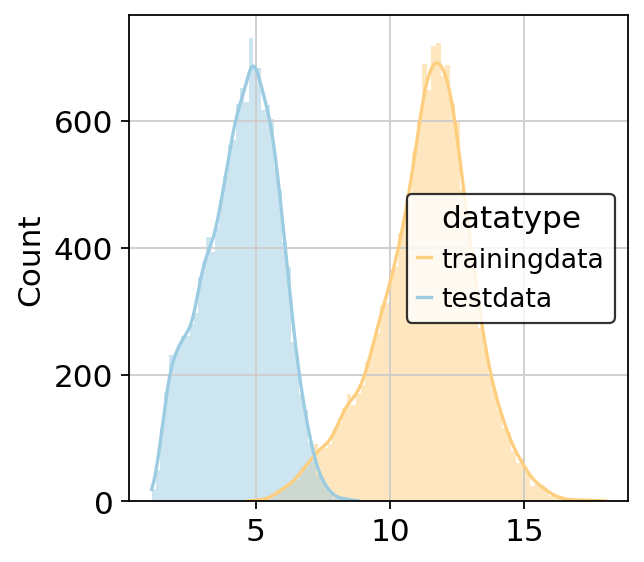

Using minmax scaler...


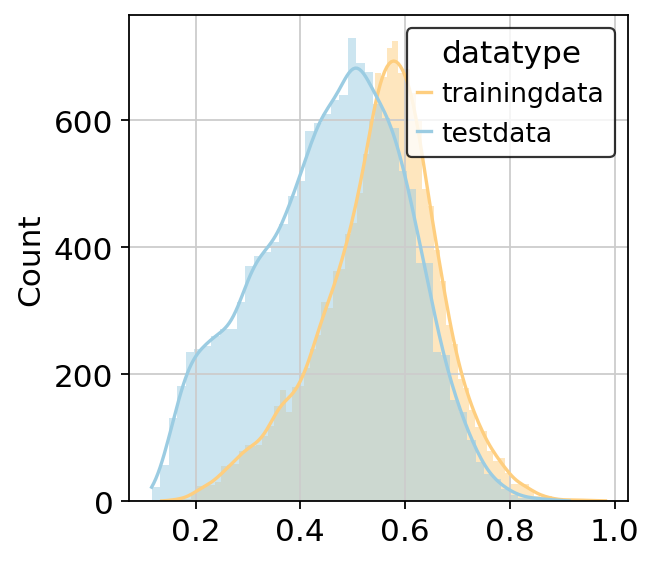

training data shape is  (5000, 14995) 
test data shape is  (75, 14995)
train model256 now


100%|██████████| 128/128 [01:45<00:00,  1.22it/s]


train model512 now


100%|██████████| 128/128 [03:36<00:00,  1.69s/it]


train model1024 now


100%|██████████| 128/128 [04:50<00:00,  2.27s/it]


Training of Scaden is done
Predicted Total Cell Num: 700.2991527534344


In [50]:
CellFractionPrediction=model.predicted_fraction()

In [51]:
CellFractionPrediction.head()

AE1       AEP    B cell     Basal  Ciliated      Club        DC  \
R2_07  0.049844  0.033023  0.038470  0.045246  0.033162  0.045871  0.041981   
R2_22  0.045621  0.042102  0.049070  0.044653  0.044550  0.045444  0.048547   
R1_74  0.038410  0.036683  0.044086  0.043470  0.037999  0.040132  0.054666   
R1_19  0.036959  0.036359  0.044029  0.036756  0.029910  0.035252  0.164163   
R2_29  0.035345  0.034857  0.041695  0.039505  0.032422  0.035116  0.052467   

       Endothelial  Fibroblast  Ionocyte  ...      Mast  Mucinous     NSCLC  \
R2_07     0.018287    0.016719  0.036633  ...  0.046511  0.031676  0.043663   
R2_22     0.050423    0.052669  0.044386  ...  0.058381  0.039516  0.048296   
R1_74     0.053647    0.051545  0.040633  ...  0.054151  0.033893  0.045531   
R1_19     0.076121    0.080631  0.033653  ...  0.042205  0.029583  0.037682   
R2_29     0.076042    0.092655  0.034470  ...  0.047608  0.028599  0.041963   

       Neuroendocrine  Neutrophil  Plasma cell    SCLC-A    SCLC-N    SCLC-P  \
R2_07        0.037413    0.043314     0.044789  0.042290  0.112373  0.052529   
R2_22        0.045659    0.045762     0.046909  0.029160  0.104481  0.052979   
R1_74        0.043165    0.044635     0.044465  0.025868  0.147142  0.050477   
R1_19        0.040480    0.041943     0.037321  0.017542  0.037006  0.042357   
R2_29        0.040335    0.041654     0.041565  0.032444  0.142769  0.047184   

         T cell  
R2_07  0.150947  
R2_22  0.040284  
R1_74  0.042975  
R1_19  0.056371  
R2_29  0.040677  

[5 rows x 21 columns]

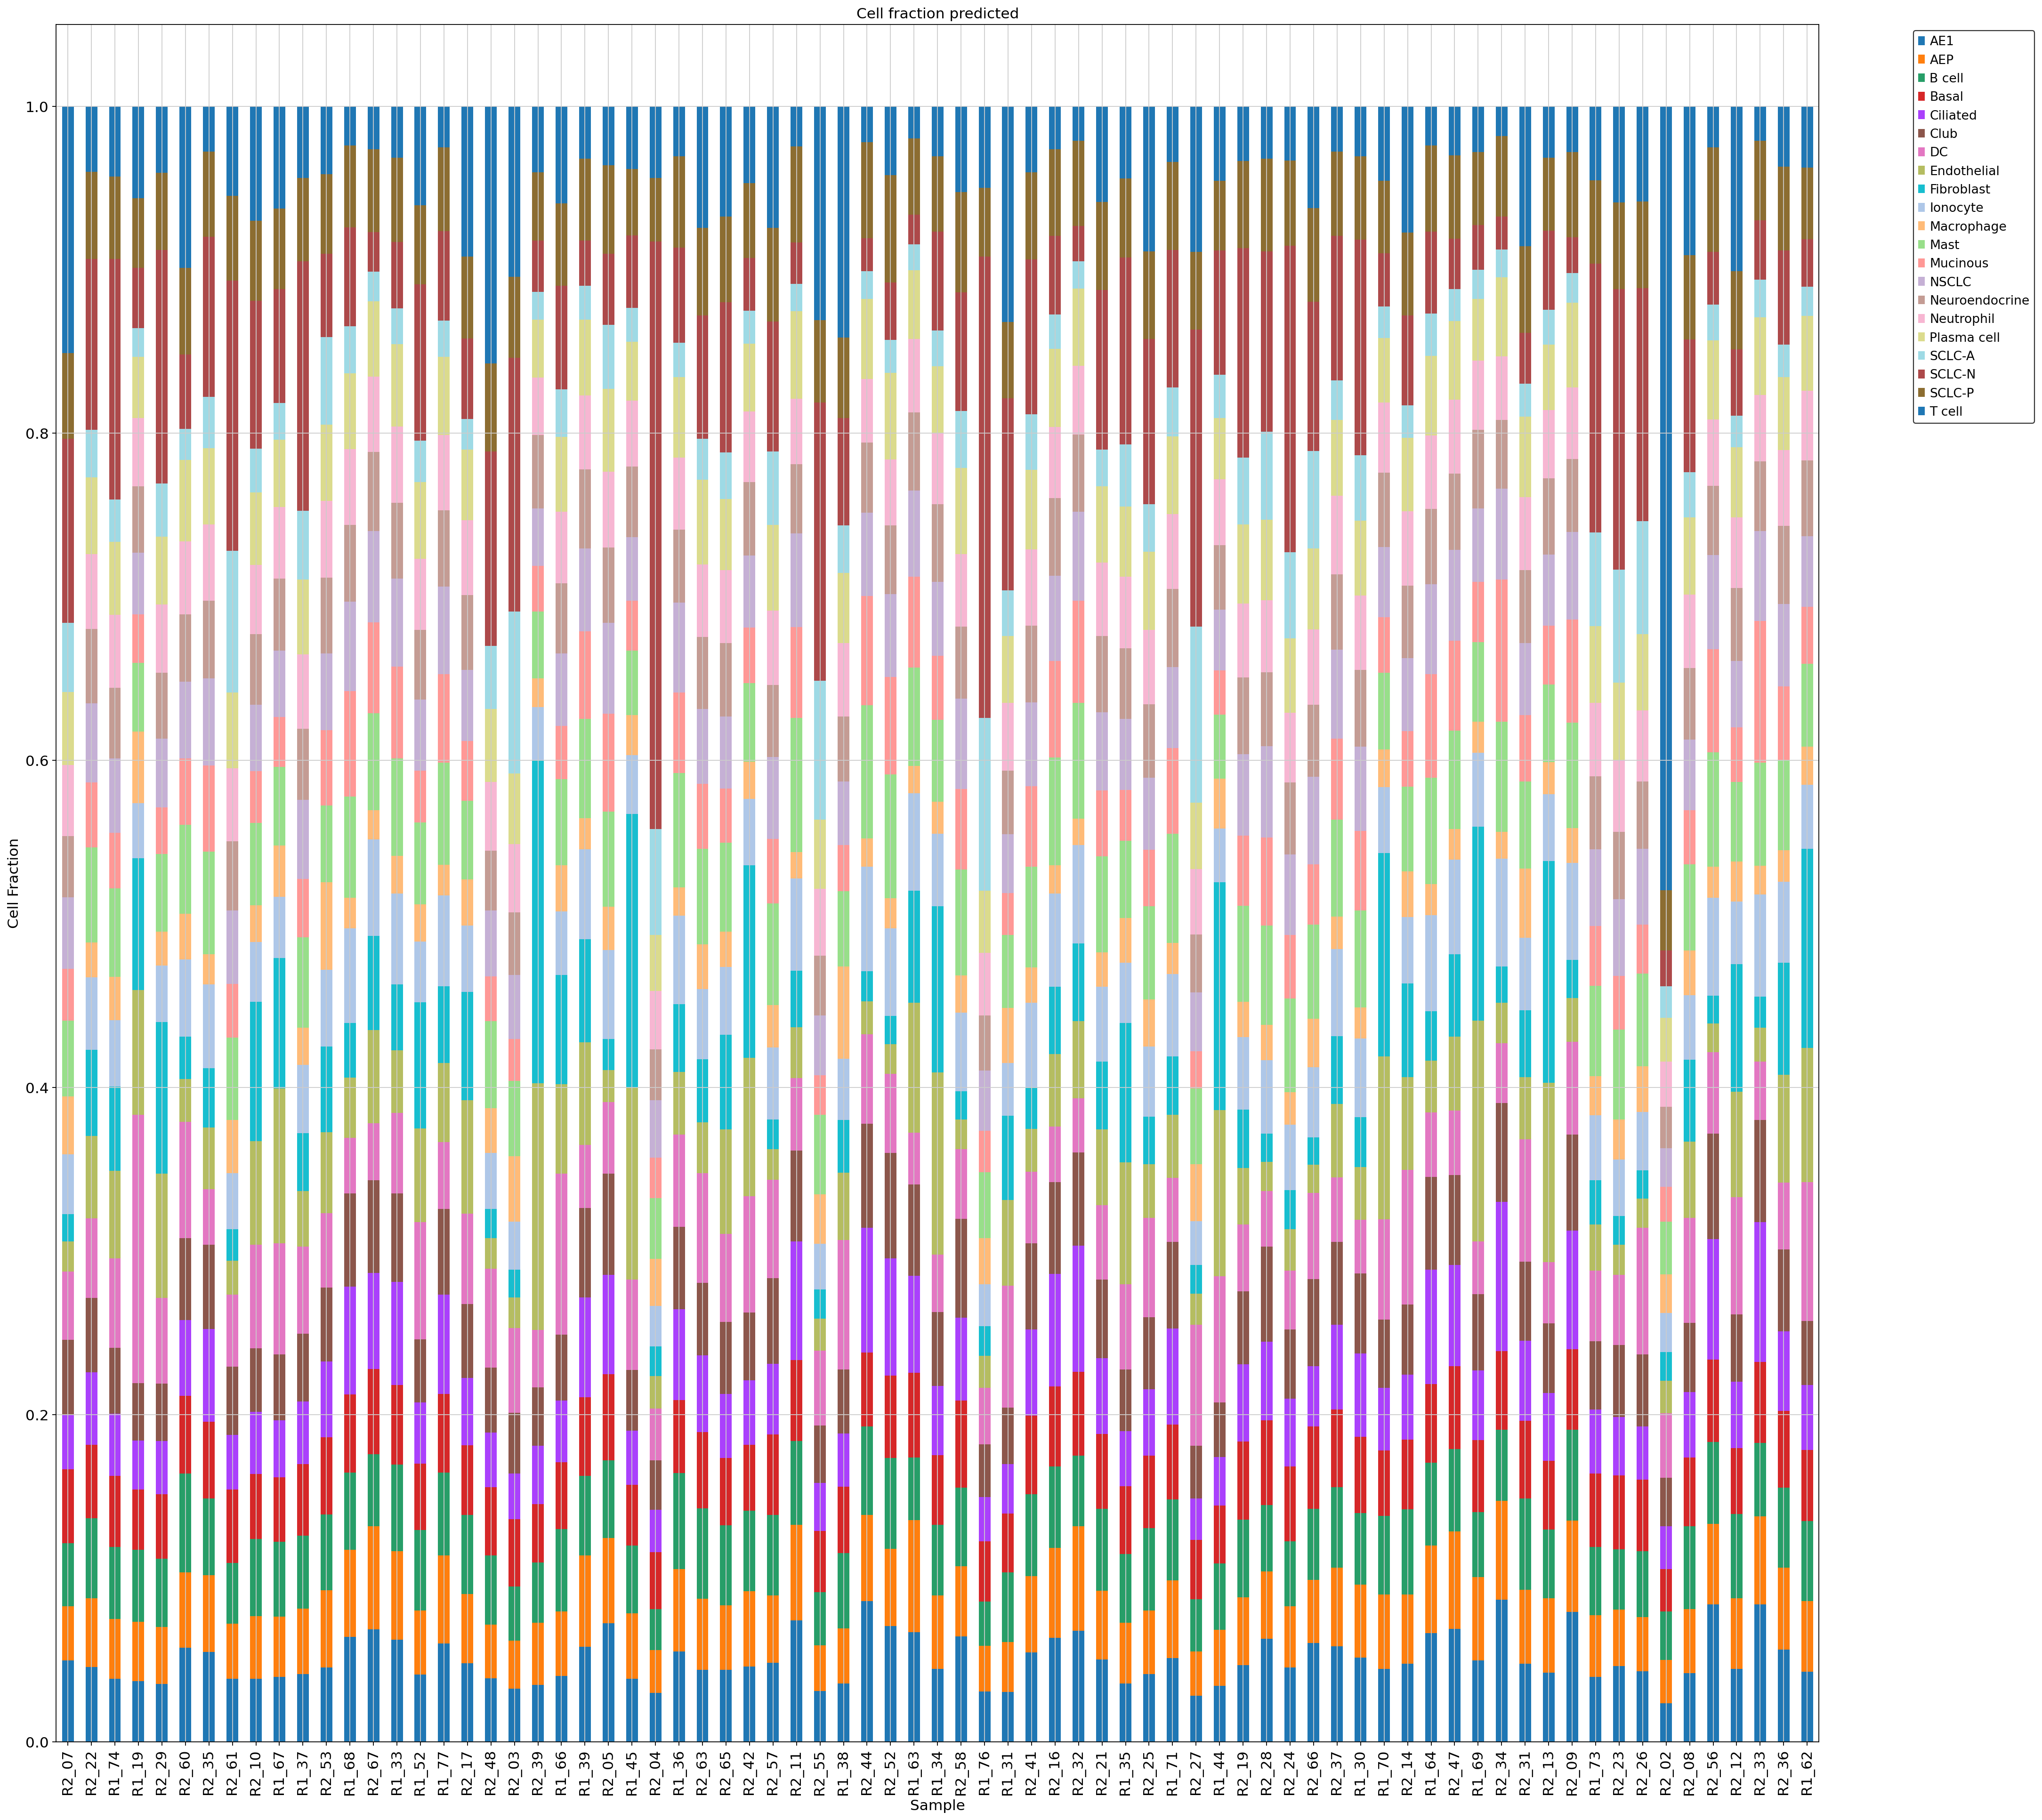

In [52]:
ax = CellFractionPrediction.plot(kind='bar', stacked=True, figsize=(30, 30))
ax.set_xlabel('Sample')
ax.set_ylabel('Cell Fraction')
ax.set_title('Cell fraction predicted')
plt.legend(bbox_to_anchor=(1.05, 1),ncol=1,)
plt.show()

## Bulk2single training - cell number for each sample


In [54]:
# model.bulk_preprocess_lazy()
# model.single_preprocess_lazy()
# model.prepare_input()

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


### Training the VAE model 

In [ ]:
# vae_net=model.train(
#     batch_size=512,
#     learning_rate=1e-4,
#     hidden_size=256,
#     epoch_num=25,
#     vae_save_dir='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model',
#     vae_save_name='dg_vae',
#     generate_save_dir='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/output',
#     generate_save_name='dg')

In [53]:
model.load_fraction('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model/dg_vae_cell_target_num.pkl')



In [54]:
model.bulk_preprocess_lazy()
model.single_preprocess_lazy()
model.prepare_input()

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


In [55]:
vae_net=model.load(vae_load_dir='/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model/dg_vae.pth')


loading model from /mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/data/bulk2single/save_model/dg_vae.pth


(<Figure size 320x320 with 1 Axes>,
 <AxesSubplot: title={'center': 'Beta-VAE'}, xlabel='Epochs', ylabel='Loss'>)

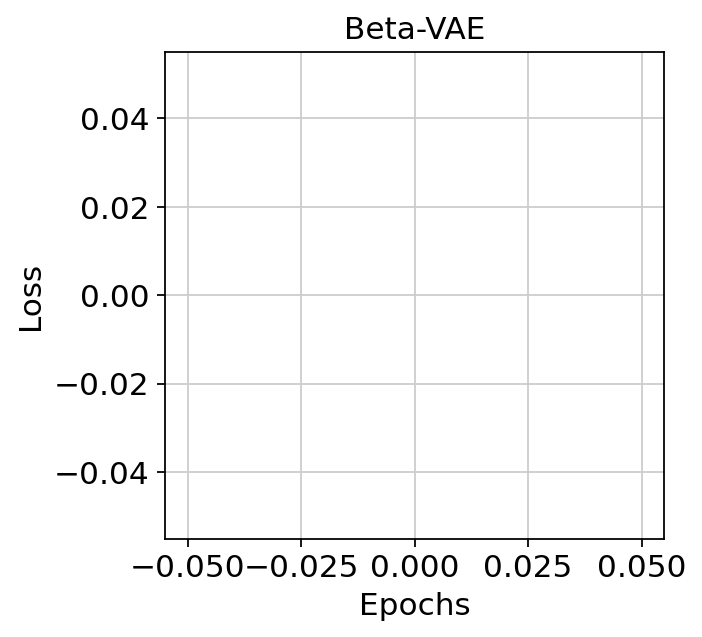

In [70]:
model.plot_loss()

In [56]:
generate_adata=model.generate()
generate_adata

...generating


generating:   0%|          | 0/1417 [00:00<?, ?it/s]

generating: 100%|██████████| 1417/1417 [00:01<00:00, 928.19it/s] 

generated done!


AnnData object with n_obs × n_vars = 1417 × 15138
    obs: 'cell_type_fine'

In [57]:
generate_adata=model.filtered(generate_adata,leiden_size=25)
generate_adata

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=100
    finished (0:00:01)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
The filter leiden is  ['24', '25', '26', '27', '28', '29', '30', '31']


View of AnnData object with n_obs × n_vars = 1296 × 2739
    obs: 'cell_type_fine', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

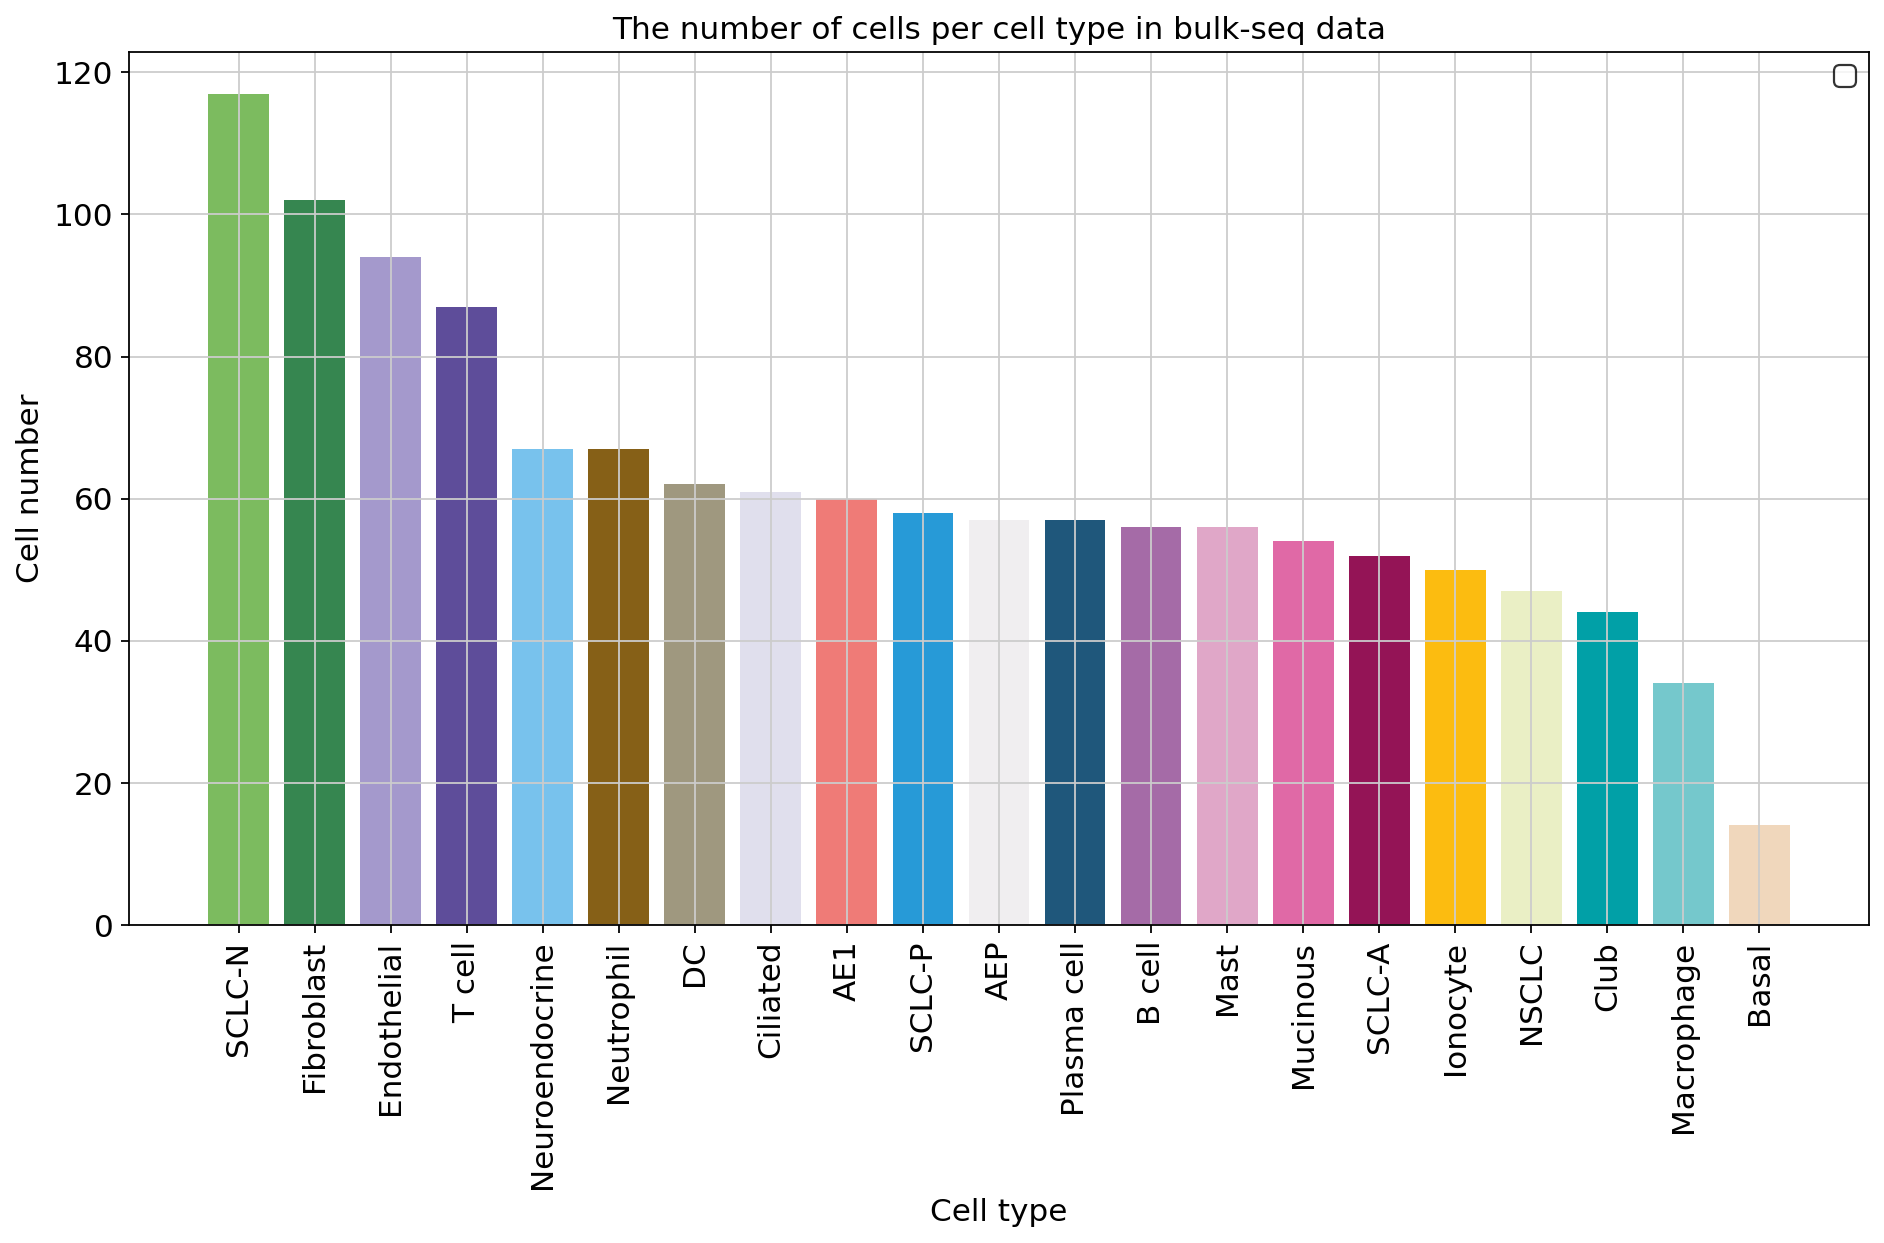

In [58]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = ov.bulk2single.bulk2single_plot_cellprop(generate_adata,celltype_key='cell_type_fine')

    
    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [59]:
sc_adata.obs["cell_type_fine"].value_counts()

SCLC-A            23782
T cell            12757
SCLC-N             6165
Macrophage         3424
DC                 1372
B cell              347
Fibroblast          314
Endothelial         250
AE1                 249
Mast                219
AEP                 185
Ciliated            165
Ionocyte             81
NSCLC                69
Mucinous             60
Basal                55
SCLC-P               42
Club                 41
Neutrophil           39
Neuroendocrine       14
Plasma cell          14
Name: cell_type_fine, dtype: int64

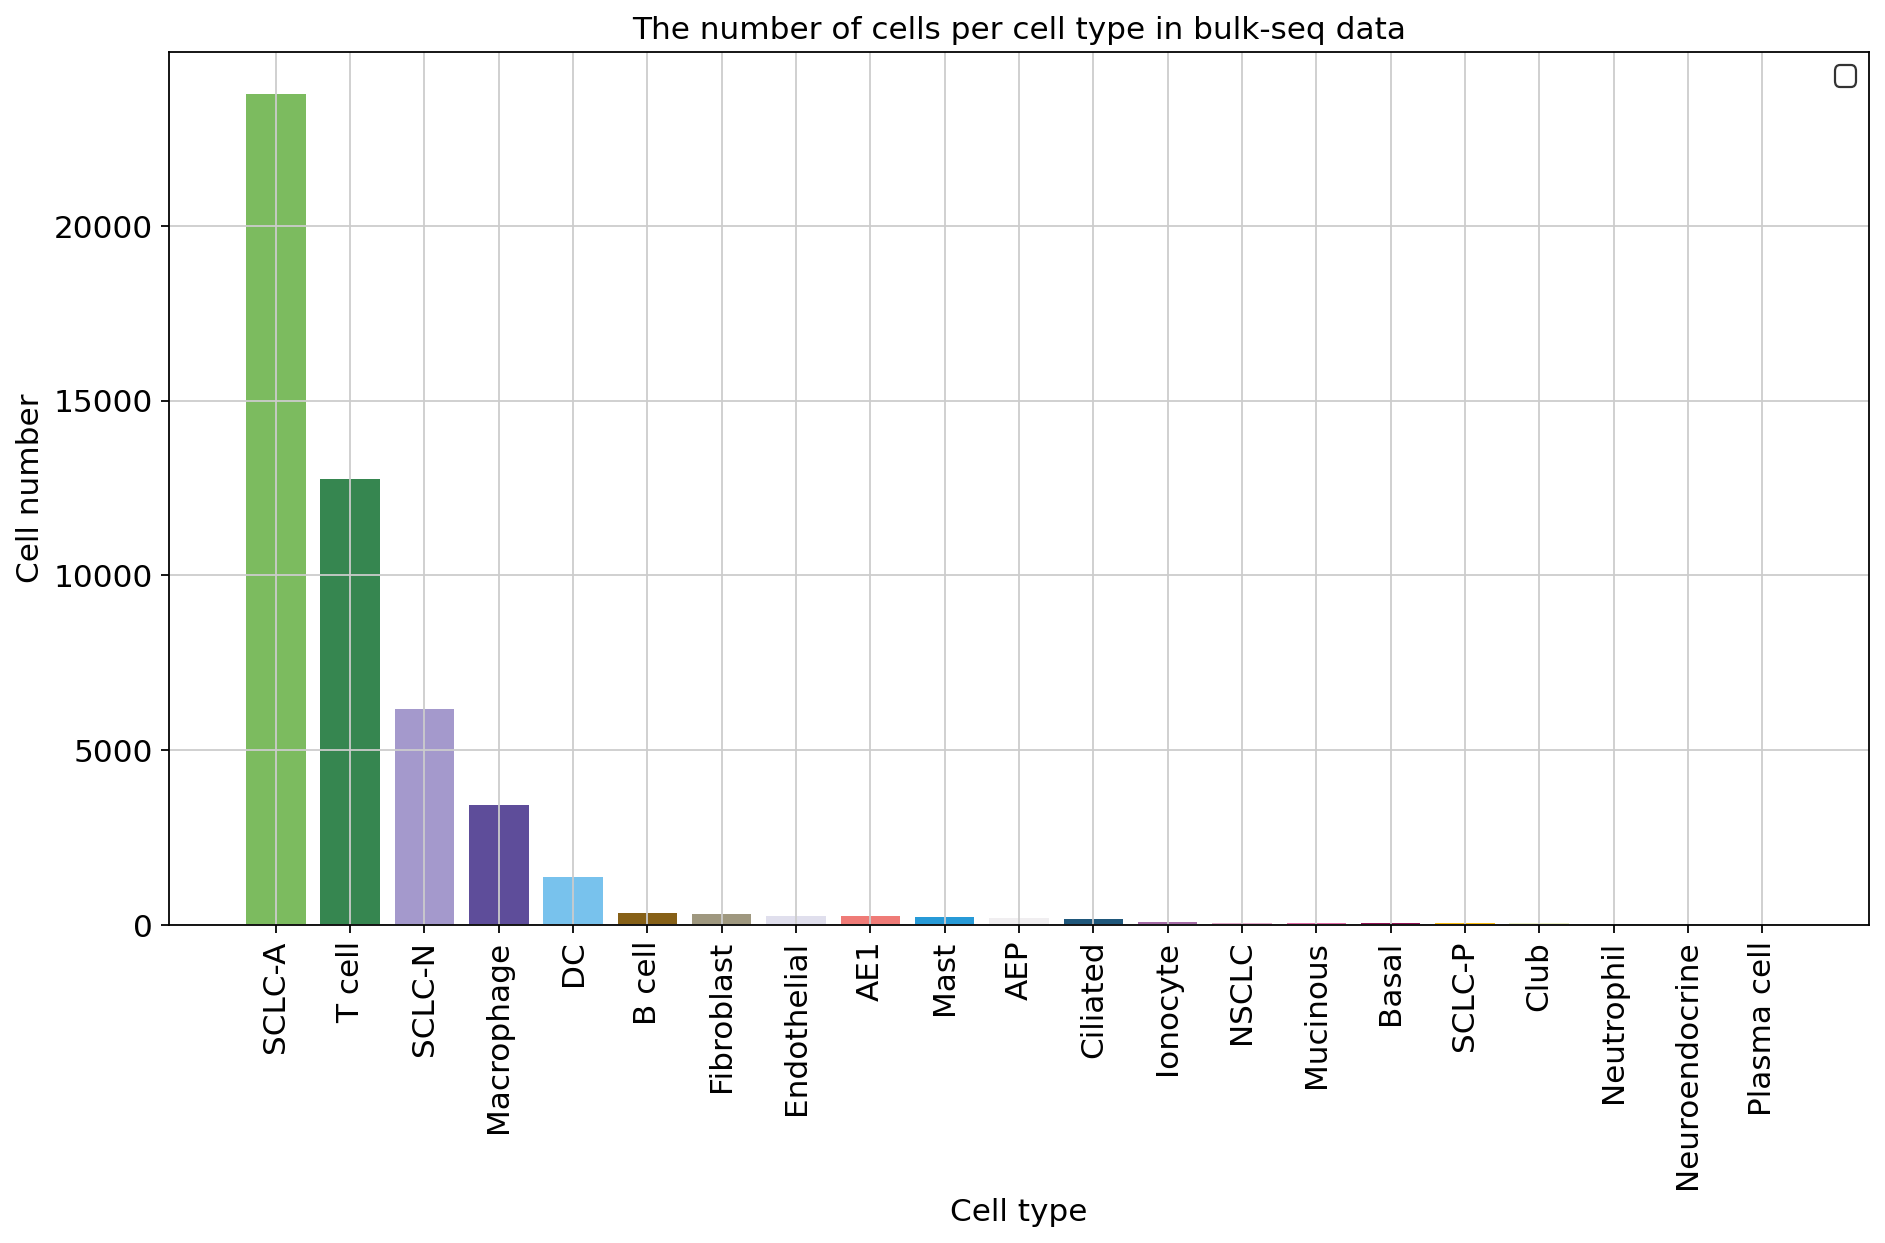

In [60]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):
    plot_func = ov.bulk2single.bulk2single_plot_cellprop(sc_adata,celltype_key='cell_type_fine')


    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [62]:
sc_adata.X = sc_adata.layers["lognorm_counts"].copy()
sc_adata.raw = sc_adata

In [63]:

# Use rc_context to temporarily set the figure size
with plt.rc_context({'figure.figsize': (12, 8)}):

    plot_func = ov.bulk2single.bulk2single_plot_correlation(sc_adata,generate_adata,celltype_key='cell_type_fine')

    fig = plt.gcf()  # Get the current figure
    fig.set_size_inches(12, 8)  # Set the figure size manually
    
    ax = plt.gca()  # Get the current axis
    ax.legend(loc='best')  # Customize the legend (rcParams will handle color)
    
    # Use tight_layout to adjust layout
    plt.tight_layout()

    # Save the figure, ensuring no elements are cut off
    # fig.savefig('/mnt/work/RO_src/STAnalysis/notebooks/downstream/Bulk RNA/your_figure_name.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

ranking genes


In [ ]:
generate_adata.obsm["X_mde"] = ov.utils.mde(generate_adata.obsm["X_pca"])
ov.utils.embedding(generate_adata,basis='X_mde',color=['clusters'],wspace=0.4,
          palette=ov.utils.pyomic_palette(),frameon='small')

In [ ]:
sc_adata.X = sc_adata.layers["raw_counts"].copy()
sc_adata.raw = sc_adata.copy()